In [203]:
# !pip install torch
# !pip install transformers datasets
# !pip install scikit-learn
# !pip install seaborn
# !pip install text2num
# !pip install torchmetrics
# !pip install evaluate
# !pip install wandb
# !pip install accelerate

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, urllib.request, sys, json, random, math, itertools, re, string, inspect, functools, collections, gc
from tqdm.auto import tqdm
from typing import List, Optional, Union, Tuple, Dict, Any
from dataclasses import dataclass
from enum import Enum, auto
from collections import defaultdict

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import transformers, datasets
from transformers import AutoTokenizer, AutoModel, EncoderDecoderModel
from accelerate import Accelerator

import wandb

from src.generate_annotation import annotate_dataset, create_readable_dataset, to_readable_story, AnswerType
from src.preprocessing import *
from src.train import DynamicPaddingCollatorForSeq2Seq, save_checkpoint, load_checkpoint, DummyScheduler
from src.utils import *
from src.config import Config
from src.squad_f1 import squad_f1
from src.losses import EncoderDecoderRationaleLoss, encoder_decoder_generative_loss, EncoderRationaleLoss, UncertaintyLoss, ComputeLoss, Criterion
from src.evaluation import Metric, EncoderDecoderRationaleAccuracy, EncoderDecoderRationaleF1, GenerativeAccuracy, GenerativeSquadF1, EncoderRationaleAccuracy, EncoderRationaleF1

# keep datasets in memory if < 8 GB
datasets.config.IN_MEMORY_MAX_SIZE = 8 * 1024**3
CONFIG: Config = Config()

# [Task 1] Remove unaswerable QA pairs

## Download the dataset

In [3]:
class DownloadProgressBar(tqdm):

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B',
                             unit_scale=True,
                             miniters=1,
                             desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_path,
                                   reporthook=t.update_to)


def download_data(url_path, output_path, split):
    create_dirs_for_file(output_path)

    if not os.path.exists(output_path):
        print(f"Downloading CoQA {split} data split... (it may take a while)")
        download_url(url=url_path, output_path=output_path)
        print("Download completed!")

In [4]:
download_data(CONFIG.dataset.train_url, CONFIG.dataset.train_data_raw, "train")
download_data(CONFIG.dataset.test_url, CONFIG.dataset.test_data_raw, "test")

coqa-train-v1.0.json: 0.00B [00:00, ?B/s]

Download completed!


coqa-dev-v1.0.json: 0.00B [00:00, ?B/s]

Download completed!


## Remove unanswerable QA pairs

We perform an automated annotation process, where we assign each answer a specific answer type:
- `unknown`: unanswerable question - we check if (`span_start`, `span_end`) = (-1, -1)
- `span`: answer overlaps with the passage, after ignoring punctuation and case mismatches
- `yes_no`: answer is Yes or No
- `counting`: answer is the result of a counting process - we check if the answer is a written number or a digit
- `multiple_choice`: answer is one the choices provided in the question - we check if the question has an `or` and contains the answer
- `fluency`: changes to the text span to improve fluency - if the answer is none of the previous, we flag it as `fluency`

Although the automated annotation procedure is susceptible to errors, with some `span` answers being annotated as `counting`, we believe that it is reliable and provides a useful starting point for analyzing the dataset.

In [5]:
def generate_annotated_dataset(raw_filename,
                               annotated_filename,
                               ignore_additional_answers=True):
    if not os.path.exists(annotated_filename):
        print("Generating annotated data...", end="")
        annotate_dataset(raw_filename,
                         annotated_filename,
                         ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_annotated_dataset(CONFIG.dataset.train_data_raw,
                           CONFIG.dataset.train_data_annotated)

generate_annotated_dataset(CONFIG.dataset.test_data_raw,
                           CONFIG.dataset.test_data_annotated)

Generating annotated data...Done!
Generating annotated data...Done!


In [6]:
target = datasets.load_dataset("json",
                             data_files=CONFIG.dataset.train_data_annotated,
                             field="data")
test_data = datasets.load_dataset(
    "json",
    data_files=CONFIG.dataset.test_data_annotated,
    field="data",
    split="train")
target["test"] = test_data.remove_columns(
    list(set(test_data.features).difference(target["train"].features)))

print(target)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/Simone999/.cache/huggingface/datasets/json/default-b265b26eae6c2838/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to C:/Users/Simone999/.cache/huggingface/datasets/json/default-7771f884df1444cb/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4. Subsequent calls will reuse this data.
DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id'],
        num_rows: 500
    })
})


Let's remove unknown qa pairs.

In [7]:
def remove_unknown_qa(example):
    questions = []
    answers = []
    last_turn = 0
    for question_item, answer_item in zip(example["questions"],
                                          example["answers"]):
        last_turn += 1
        if question_item["answer_type"] != "unknown":
            questions.append(question_item)
            answers.append(answer_item)

    qa_length = len(questions)
    return {
        'questions': questions,
        'answers': answers,
        'qa_length': qa_length,
        'last_turn': last_turn,
    }


print("Removing unknown qa pairs...")
filtered_dataset = target.map(remove_unknown_qa)
print("Done!")

print(filtered_dataset)

Removing unknown qa pairs...


Map:   0%|          | 0/7199 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!
DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


We have to check whether there are examples with no qa pairs and remove them from the dataset.

In [8]:
def remove_examples_with_no_qa(dataset, verbose=True):
    if verbose:
        examples_with_no_qa = dataset.filter(
            lambda example: example["qa_length"] == 0)
        print("Examples with no qa pairs:", examples_with_no_qa.num_rows)

        examples_with_no_qa = examples_with_no_qa["train"]
        examples_with_no_qa.set_format("pandas")
        display(examples_with_no_qa[:])

        print()
        print("Filtering out examples with no qa pairs...")
    filtered_dataset = dataset.filter(
        lambda example: example["qa_length"] > 0)
    if verbose:
        print("Done!")

        print()
        print("Number of examples:", filtered_dataset.num_rows)

    return filtered_dataset

In [9]:
filtered_dataset = remove_examples_with_no_qa(filtered_dataset)

Filter:   0%|          | 0/7199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Examples with no qa pairs: {'train': 6, 'test': 0}


answers                                              story questions   
0      []  The rare moments Christos Sourovelis can take ...        []  \
1      []  A senior Palestinian Authority official died W...        []   
2      []  Index Medicus (IM) is a curated subset of MEDL...        []   
3      []  Seoul, South Korea (CNN) -- Korean is consider...        []   
4      []  John was an old man who lived in New York City...        []   
5      []  Danny lived for football. He played it, watche...        []   

                                                name   
0  cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...  \
1  cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...   
2                                  Index_Medicus.txt   
3  cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...   
4                                    mc500.train.252   
5                                     middle7342.txt   

                                            filename     source   
0  cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...        cnn  \
1  cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...        cnn   
2                                  Index_Medicus.txt  wikipedia   
3  cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...        cnn   
4                                    mc500.train.252     mctest   
5                                     middle7342.txt       race   

                               id  qa_length  last_turn  
0  3igi0vl647kltzms1bysq3xdroknoh          0          1  
1  3p4rdnwnd56fenk4oitvdzka5nuija          0          1  
2  35gmh2sv3ehhzt9f8cv90g34dznoe3          0          1  
3  39rp059mehtvsncjl5e6748efztmbe          0          1  
4  3sbehtycwn359cf3aiuynmzyiykiyz          0          1  
5  3zdad0o1t1d6il54zy70ifuyshmxtm          0          1


Filtering out examples with no qa pairs...


Filter:   0%|          | 0/7199 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!

Number of examples: {'train': 7193, 'test': 500}


In [10]:
filtered_dataset.save_to_disk(CONFIG.dataset.filtered_dir)
del filtered_dataset
del target

Saving the dataset (0/1 shards):   0%|          | 0/7193 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

## Data Inspection

In [11]:
target = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
print(target)

DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 7193
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


The dataset is very difficult to explore in a Jupyter notebook. To overcome this, we create a readable `.txt` version, similar to the one provided by the authors of CoQA. For each story, the format is:

```
source: <source>, id: <id>

<passage>

turn: 1
Q   <question_1> || <question_type_1>
A   <answer_1> || <rationale_1> || <answer_type_1>
                        .
                        .
                        .
turn: i
Q   <question_i> || <question_type_i>
A   <answer_i> || <rationale_i> || <answer_type_i>
                        .
                        .
                        .
```

In [12]:
def generate_readable_dataset(annotated_filename,
                              readable_filename,
                              ignore_additional_answers=True):
    if not os.path.exists(readable_filename):
        print("Generating readable data...", end="")
        create_readable_dataset(
            annotated_filename,
            readable_filename,
            ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_readable_dataset(CONFIG.dataset.train_data_annotated,
                          CONFIG.dataset.train_data_readable)
generate_readable_dataset(CONFIG.dataset.test_data_annotated,
                          CONFIG.dataset.test_data_readable)

Generating readable data...Done!
Generating readable data...Done!


Here, we show an example of story.

In [13]:
sample_id = np.random.choice(target["train"].num_rows)
sample = target["train"][sample_id]

story_signature = set(inspect.signature(to_readable_story).parameters)
story_kwargs = {
    argument: value
    for argument, value in sample.items() if argument in story_signature
}
readable_story = to_readable_story(**story_kwargs)
print(readable_story)

source: race, id: 3oxv7eaxleqo0pnejwsj0pdg0yj63w

Presents For Children's Day Charles M. Schulz was born in 1922 in Minneapolis, the only child of a housewife and a barber. His interest in comics was encouraged by his father, who loved the funny pages. Charles M. Schulz sold seventeen cartoons to the Saturday Evening Post from 1948 to 1950 and Li'l Folks to the St. Paul Pioneer Press. Peanuts debuted on October 2, 1950, and ran without interruption for the next fifty years. Charles M. Schulz died in 2000. *IT'S A DOG'S LIFE SNOOPY It's a Dog's Life, Snoopy brings all your familiar friends together for great times and fun. *IT'S A BIG WORLD CHARLIE BROWN Charlie Brown faces some of life's little challenges with the help of Snoopy, Lucy, Peppermint Patty, Linus, and the rest of the gang in It's a Big World, Charlie Brown. *PEANUTS 2000 The last one is the special edition Peanuts 2000, which includes all the last year's Peanuts comic strip and Charles M. Schulz's famous farewell strip. Co

Let's see some statistics.

In [14]:
df = create_dataframe(target)
del target

print(f"Number of passages: {len(df)}")
print(f"Number of QA pairs: {df['qa_length'].sum()}")
print(f"Number of files: {len(df['filename'].unique())}")

Number of passages: 7693
Number of QA pairs: 115204
Number of files: 7065


In [15]:
print(f"Questions dictionary keys:\t {list(df.loc[0, 'questions'][0].keys())}")
print(f"Answers dictionary keys:\t {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'turn_id']
Answers dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'span_end', 'span_start', 'span_text', 'turn_id']


In [16]:
print("Distribution of splits: ")
split_counts = df['split'].value_counts()
print(split_counts)

Distribution of splits: 
split
train    7193
test      500
Name: count, dtype: int64


In [17]:
print("Conversations with gaps in the history (%)")
broken_hist_counts = df[
    df["qa_length"] < df["last_turn"]]["split"].value_counts()
print(broken_hist_counts / split_counts * 100)

Conversations with gaps in the history (%)
split
train    15.584596
test     11.600000
Name: count, dtype: float64


count    7693.000000
mean       14.975172
std         5.106029
min         1.000000
25%        11.000000
50%        16.000000
75%        20.000000
max        35.000000
Name: qa_length, dtype: float64

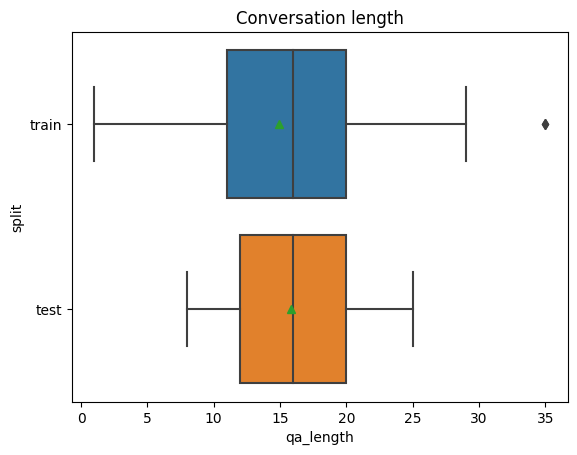

In [18]:
display(df["qa_length"].describe())
plt.title("Conversation length")
sns.boxplot(data=df, x="qa_length", y="split", showmeans=True);

Here, we want to statistics about number of words/tokens.

In [19]:
tokenizers_ = {
    k: AutoTokenizer.from_pretrained(checkpoint).tokenize
    for k, checkpoint in CONFIG.checkpoints.__dict__.items()
}
tokenizers = {"": str.split}
tokenizers.update(tokenizers_)

In [20]:
def plot_length(dataset: pd.DataFrame,
                column: str,
                column_name: Optional[str] = None,
                split_fn=str.split,
                notes: Optional[str] = None,
                max_length=None):
    if column_name is None:
        column_name = column

    length_col = column_name + "_length"
    length = dataset[column].apply(split_fn).apply(len)
    dp = dataset[["split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby("split").describe())

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    boxplot = sns.boxplot(data=dp, x=length_col, y="split", showmeans=True, ax=axes[0])
    histplot = sns.histplot(dp,
                 x=length_col,
                 hue="split",
                 stat="density",
                 common_norm=False,
                 discrete=True,
                 ax=axes[1])
    if max_length is not None:
        boxplot.axvline(x=max_length, color='red', ls='--')
        histplot.axvline(x=max_length, color='red', ls='--')
    fig.suptitle(f"{column_name.capitalize()} length ({notes})", fontsize=16)
    plt.show()

passage_length                                                          
               count      mean        std    min     25%    50%    75%     max
split                                                                         
test           500.0  261.8220  71.018995  124.0  221.75  261.0  292.0   804.0
train         7193.0  271.0228  64.901153   70.0  245.00  266.0  293.0  1030.0

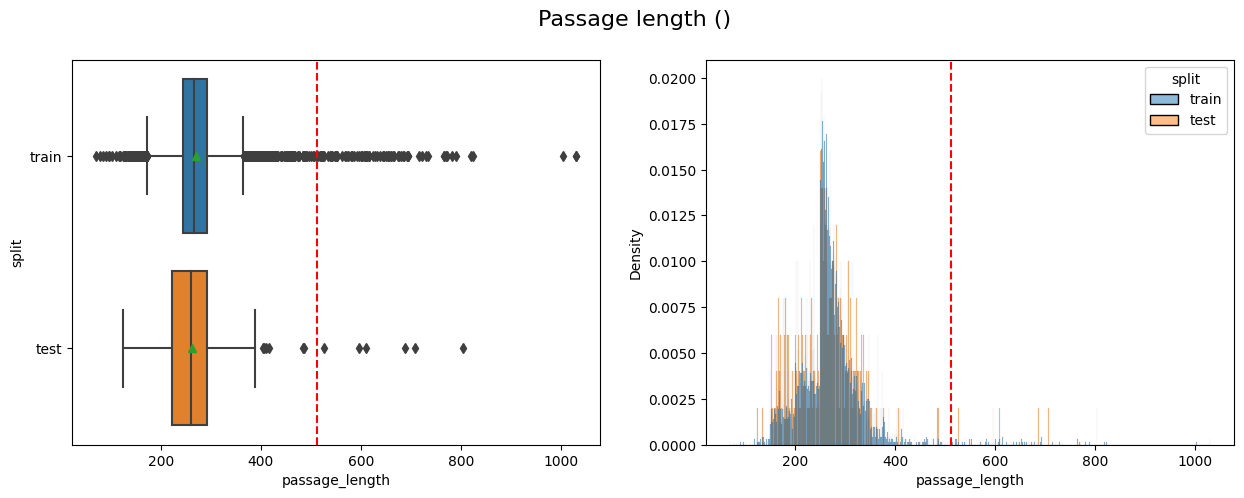

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


distil_roberta


passage_length                                                      
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  345.926000  99.027458  148.0  283.0  352.5  399.0  \
train         7193.0  362.021271  89.147521   89.0  320.0  364.0  401.0   

               
          max  
split          
test   1045.0  
train  1375.0

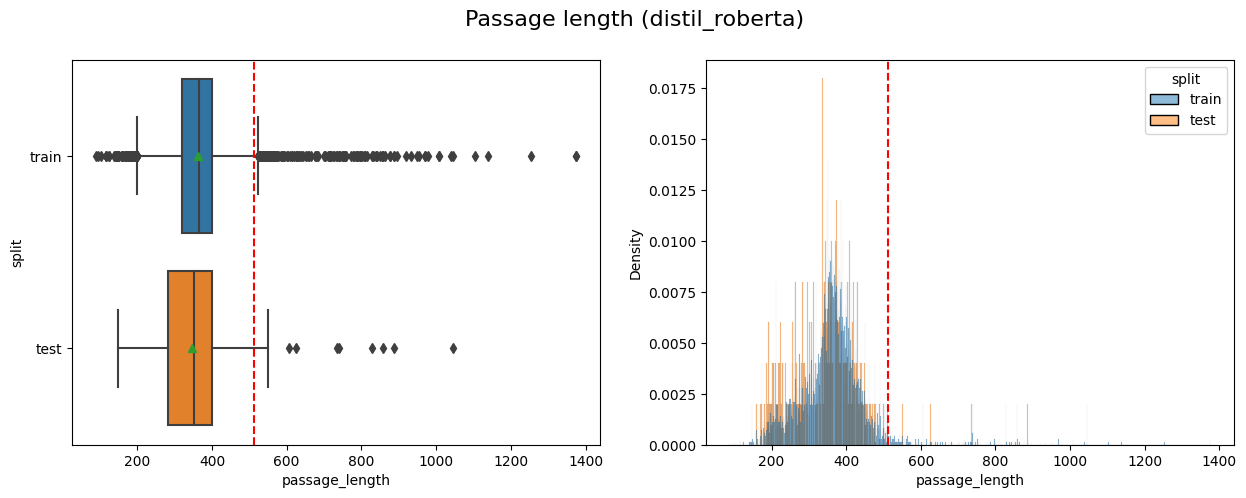

bert_tiny


passage_length                                                      
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  336.386000  95.933244  149.0  275.5  342.0  382.0  \
train         7193.0  350.610455  85.863011   87.0  310.0  349.0  387.0   

               
          max  
split          
test   1036.0  
train  1322.0

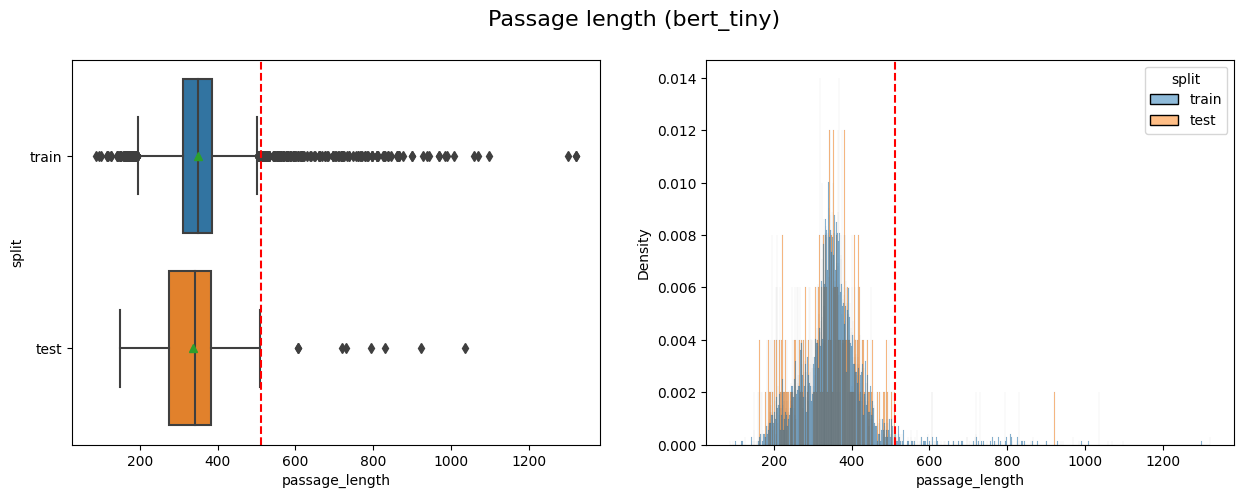

In [21]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(df,
                column="story",
                column_name="passage",
                split_fn=tokenize_fn,
                notes=checkpoint_name,
                max_length=512)

To analyze questions, answers and rationales, let's explode them.

In [22]:
qa_dataset = explode_qa(df)
assert not np.any(qa_dataset["answer_type"] == "unknown")
del df

question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  5.466279  2.458356  1.0  4.0  5.0  7.0  23.0
train        107286.0  5.457534  2.472842  1.0  4.0  5.0  7.0  42.0

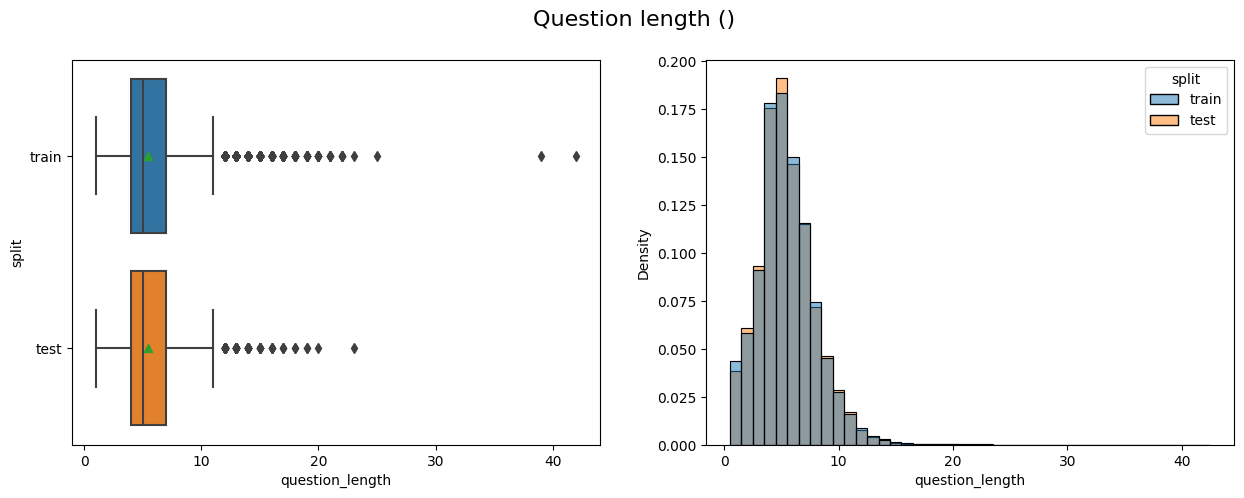

distil_roberta


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.680349  2.663522  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.709962  2.698654  1.0  5.0  6.0  8.0  51.0

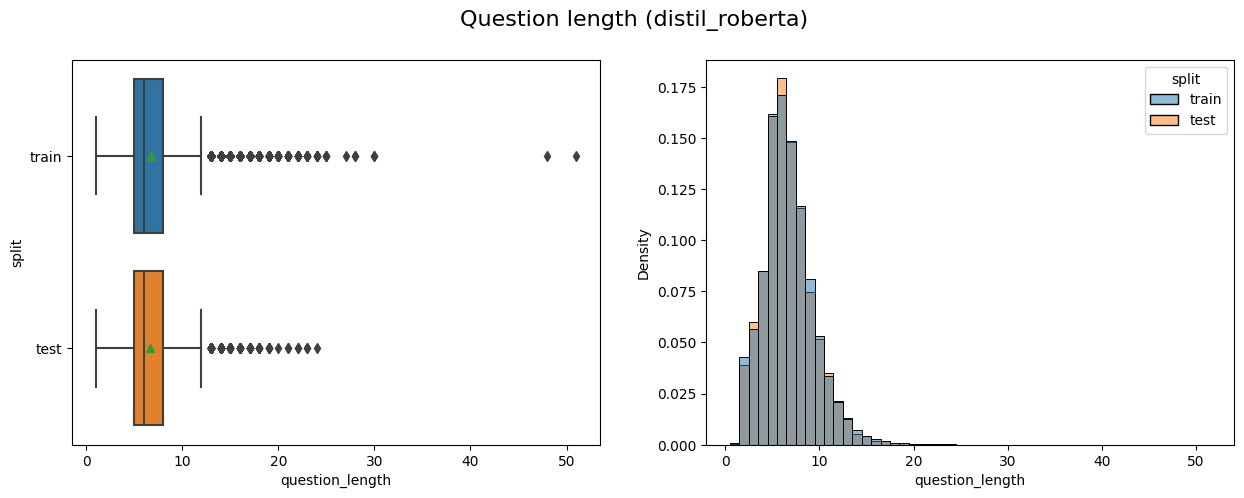

bert_tiny


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.689189  2.686615  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.718509  2.720698  1.0  5.0  6.0  8.0  51.0

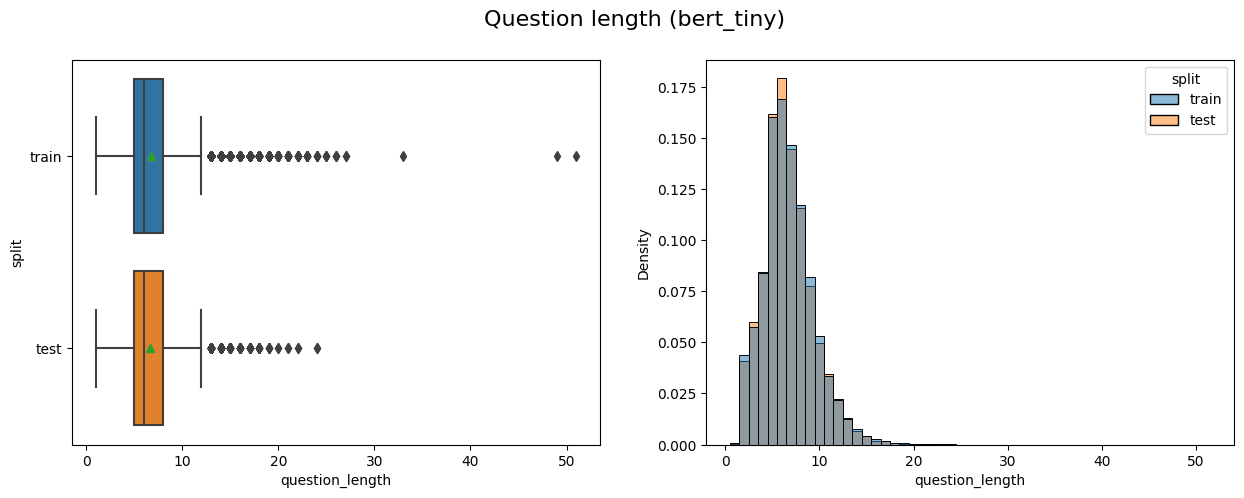

In [23]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="question",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  2.533973  2.280904  1.0  1.0  2.0  3.0   21.0
train      107286.0  2.674934  2.928911  1.0  1.0  2.0  3.0  353.0

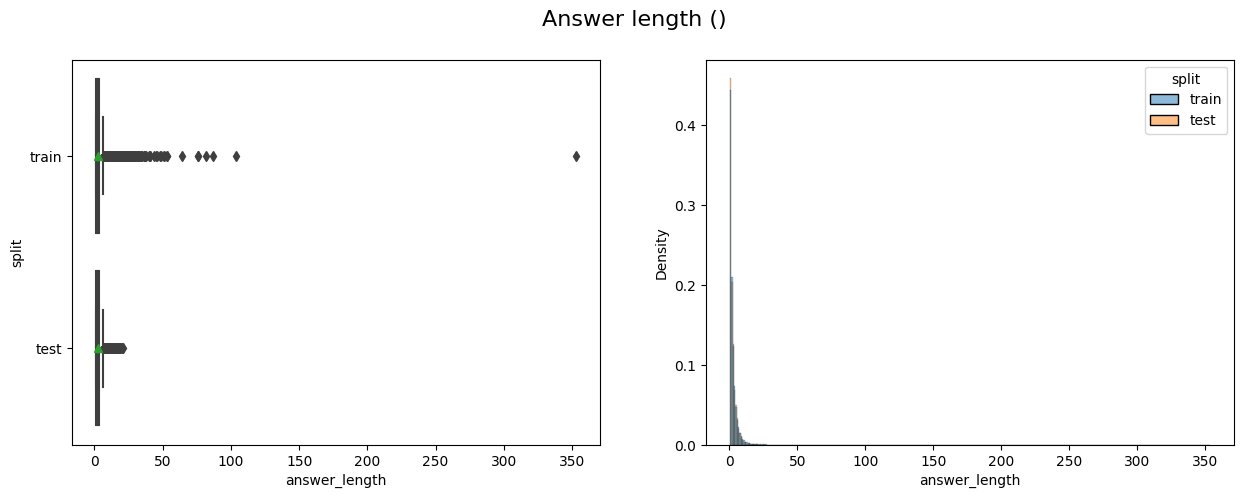

distil_roberta


answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  3.382167  2.936393  1.0  1.0  3.0  4.0   44.0
train      107286.0  3.571137  3.681034  1.0  1.0  3.0  5.0  416.0

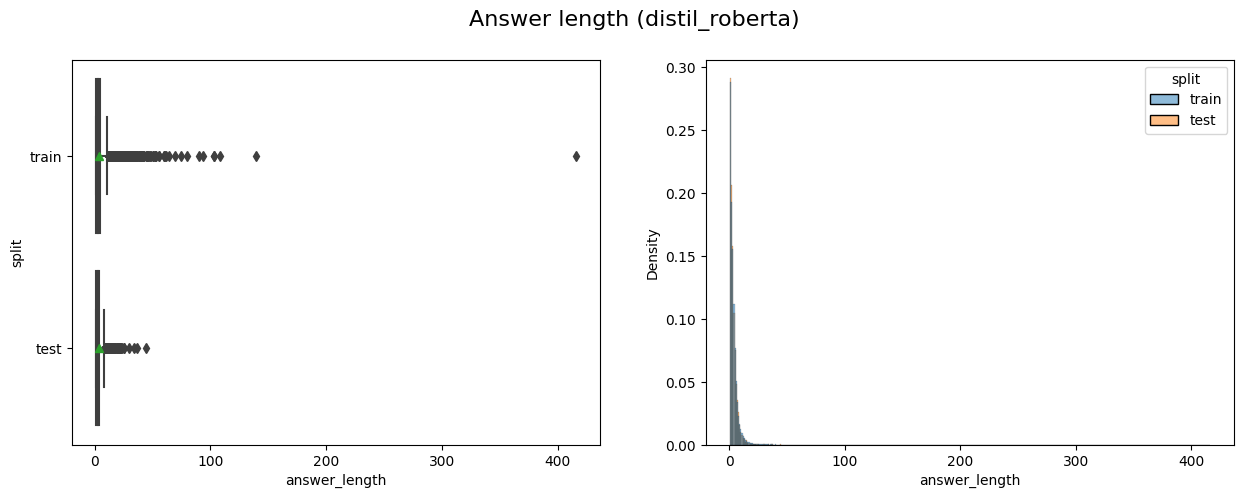

bert_tiny


answer_length                                               
              count      mean       std  min  25%  50%  75%    max
split                                                             
test         7918.0  3.160647  2.913724  1.0  1.0  2.0  4.0   34.0
train      107286.0  3.342337  3.696387  1.0  1.0  2.0  4.0  425.0

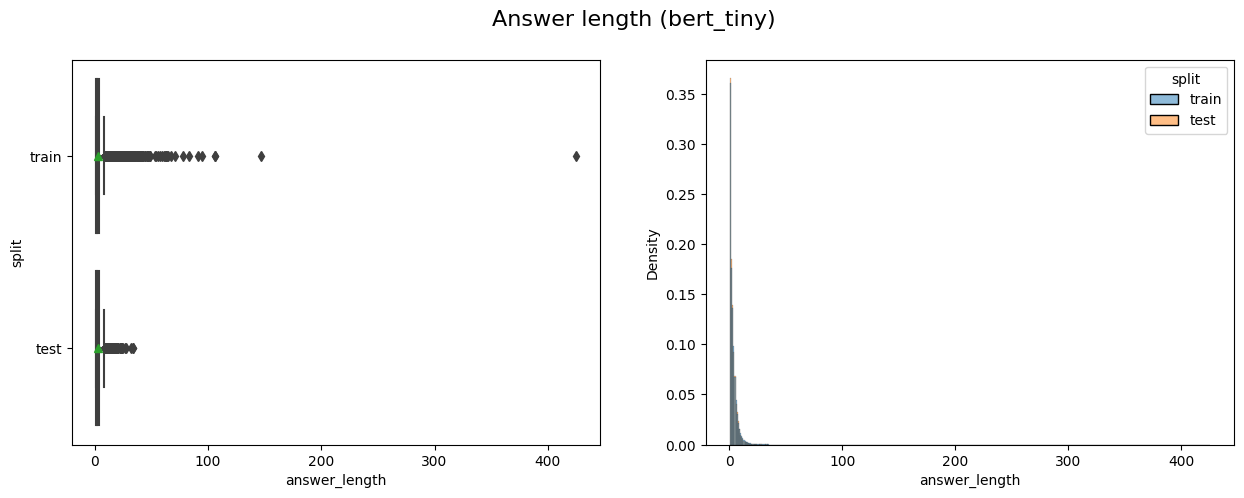

In [24]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="answer",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

There are some very long answers. It's likely most of them are trash and can be removed from the dataset.

Let's inspect the answer length per answer_type.

answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0  \
                train         946.0  1.003171  0.056254  1.0  1.0  1.0  1.0   
fluency         test         1003.0  4.393819  2.612621  1.0  2.0  4.0  6.0   
                train       13760.0  4.591715  3.158785  1.0  2.0  4.0  6.0   
multiple_choice test           33.0  1.090909  0.291937  1.0  1.0  1.0  1.0   
                train         262.0  1.175573  0.553372  1.0  1.0  1.0  1.0   
span            test         5192.0  2.682974  2.268704  1.0  1.0  2.0  3.0   
                train       71348.0  2.825153  3.061596  1.0  1.0  2.0  3.0   
yes_no          test         1619.0  1.000618  0.024853  1.0  1.0  1.0  1.0   
                train       20970.0  1.000238  0.015440  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    2.0  
fluency         test    20.0  
                train   64.0  
multiple_choice test     2.0  
                train    5.0  
span            test    21.0  
                train  353.0  
yes_no          test     2.0  
                train    2.0

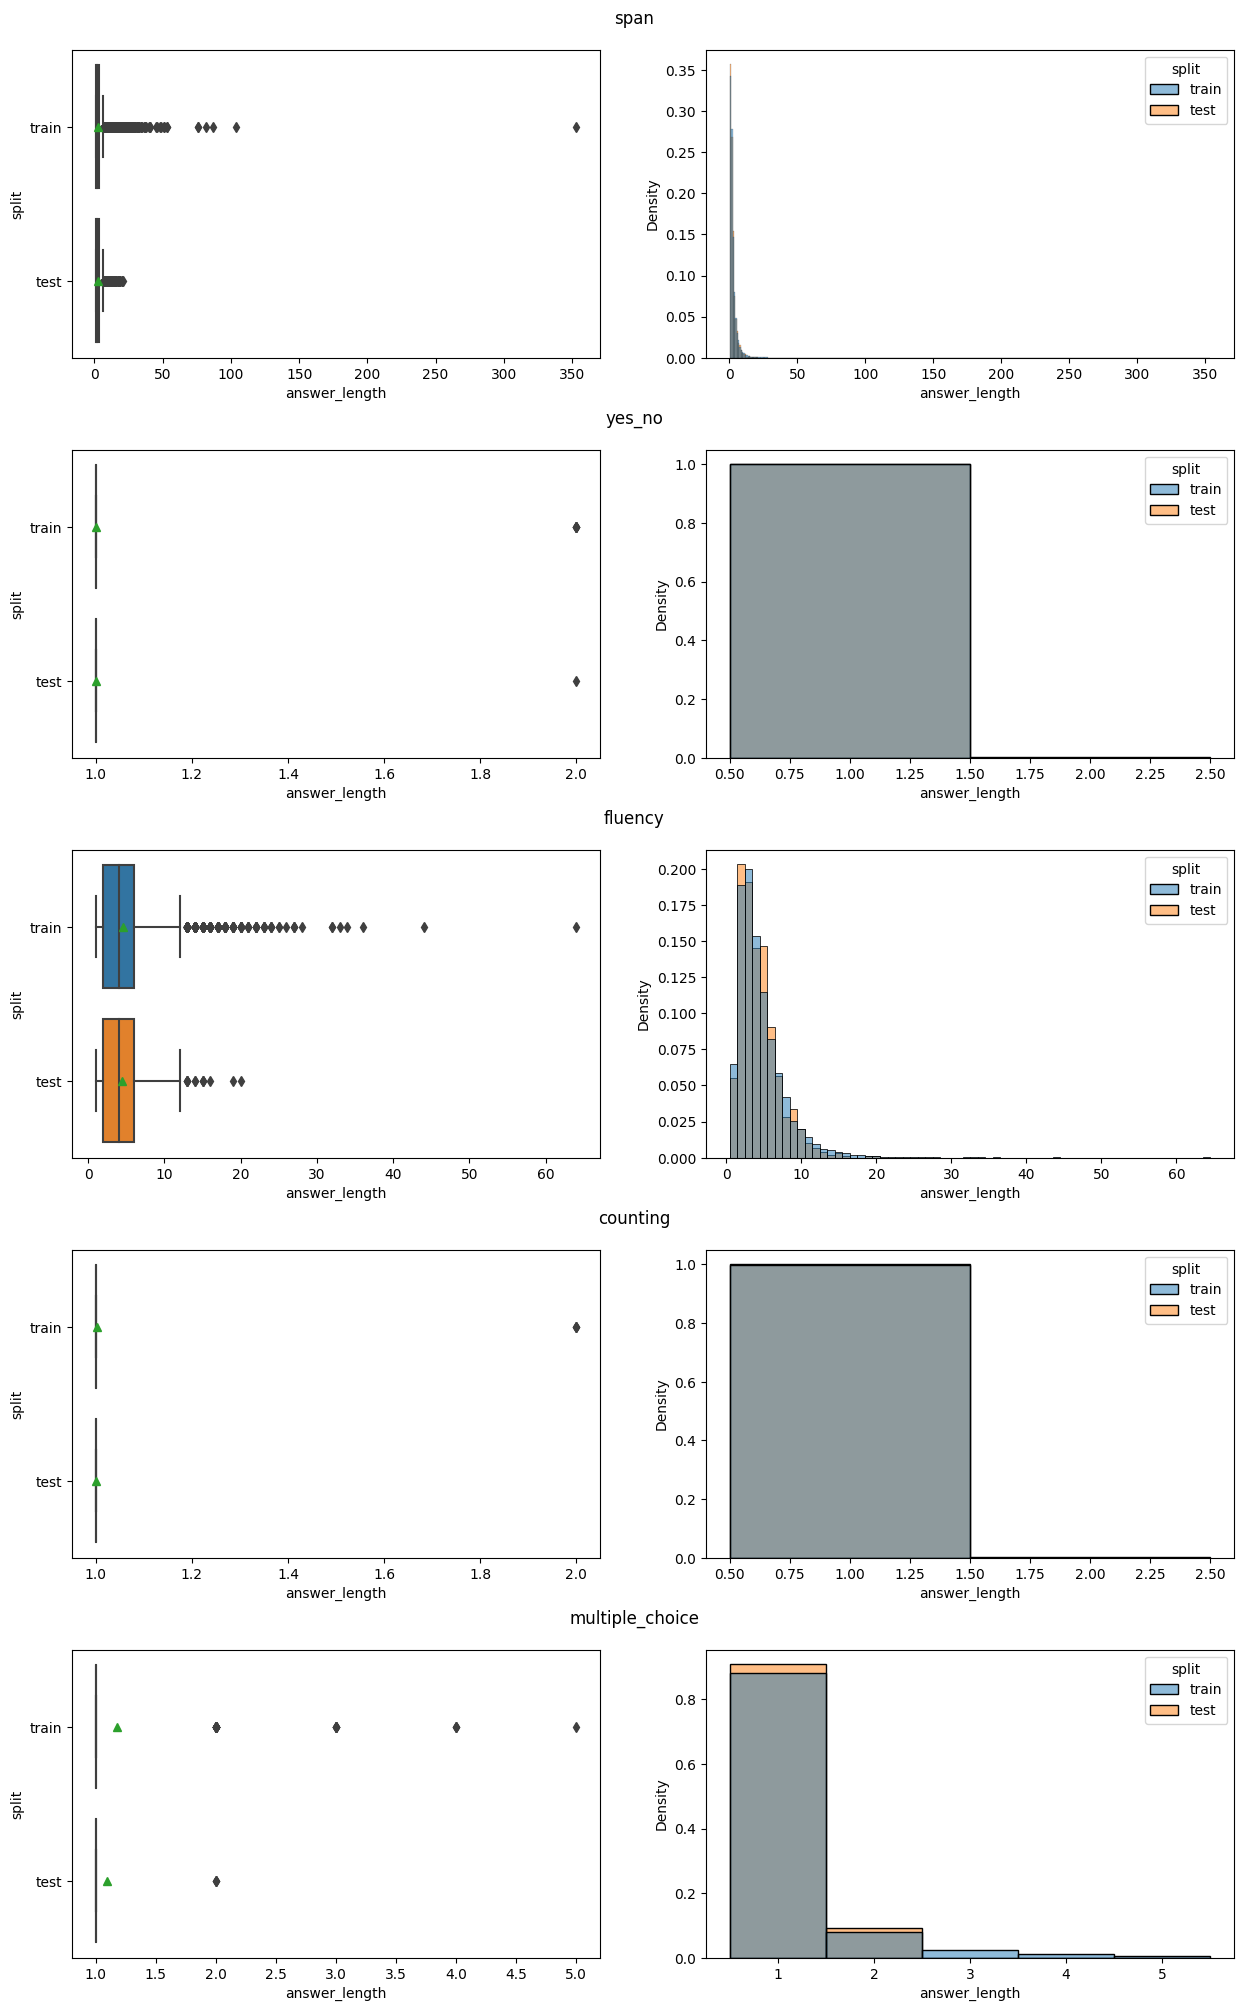

distil_roberta


answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.112676  0.360527  1.0  1.0  1.0  1.0  \
                train         946.0  1.140592  0.608842  1.0  1.0  1.0  1.0   
fluency         test         1003.0  5.357926  3.104710  1.0  3.0  5.0  7.0   
                train       13760.0  5.630596  3.837298  1.0  3.0  5.0  7.0   
multiple_choice test           33.0  1.515152  0.712444  1.0  1.0  1.0  2.0   
                train         262.0  1.469466  0.756215  1.0  1.0  1.0  2.0   
span            test         5192.0  3.757704  2.938370  1.0  2.0  3.0  5.0   
                train       71348.0  3.947735  3.823792  1.0  2.0  3.0  5.0   
yes_no          test         1619.0  1.091414  0.290423  1.0  1.0  1.0  1.0   
                train       20970.0  1.074344  0.264689  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     3.0  
                train   11.0  
fluency         test    24.0  
                train   75.0  
multiple_choice test     3.0  
                train    6.0  
span            test    44.0  
                train  416.0  
yes_no          test     3.0  
                train    3.0

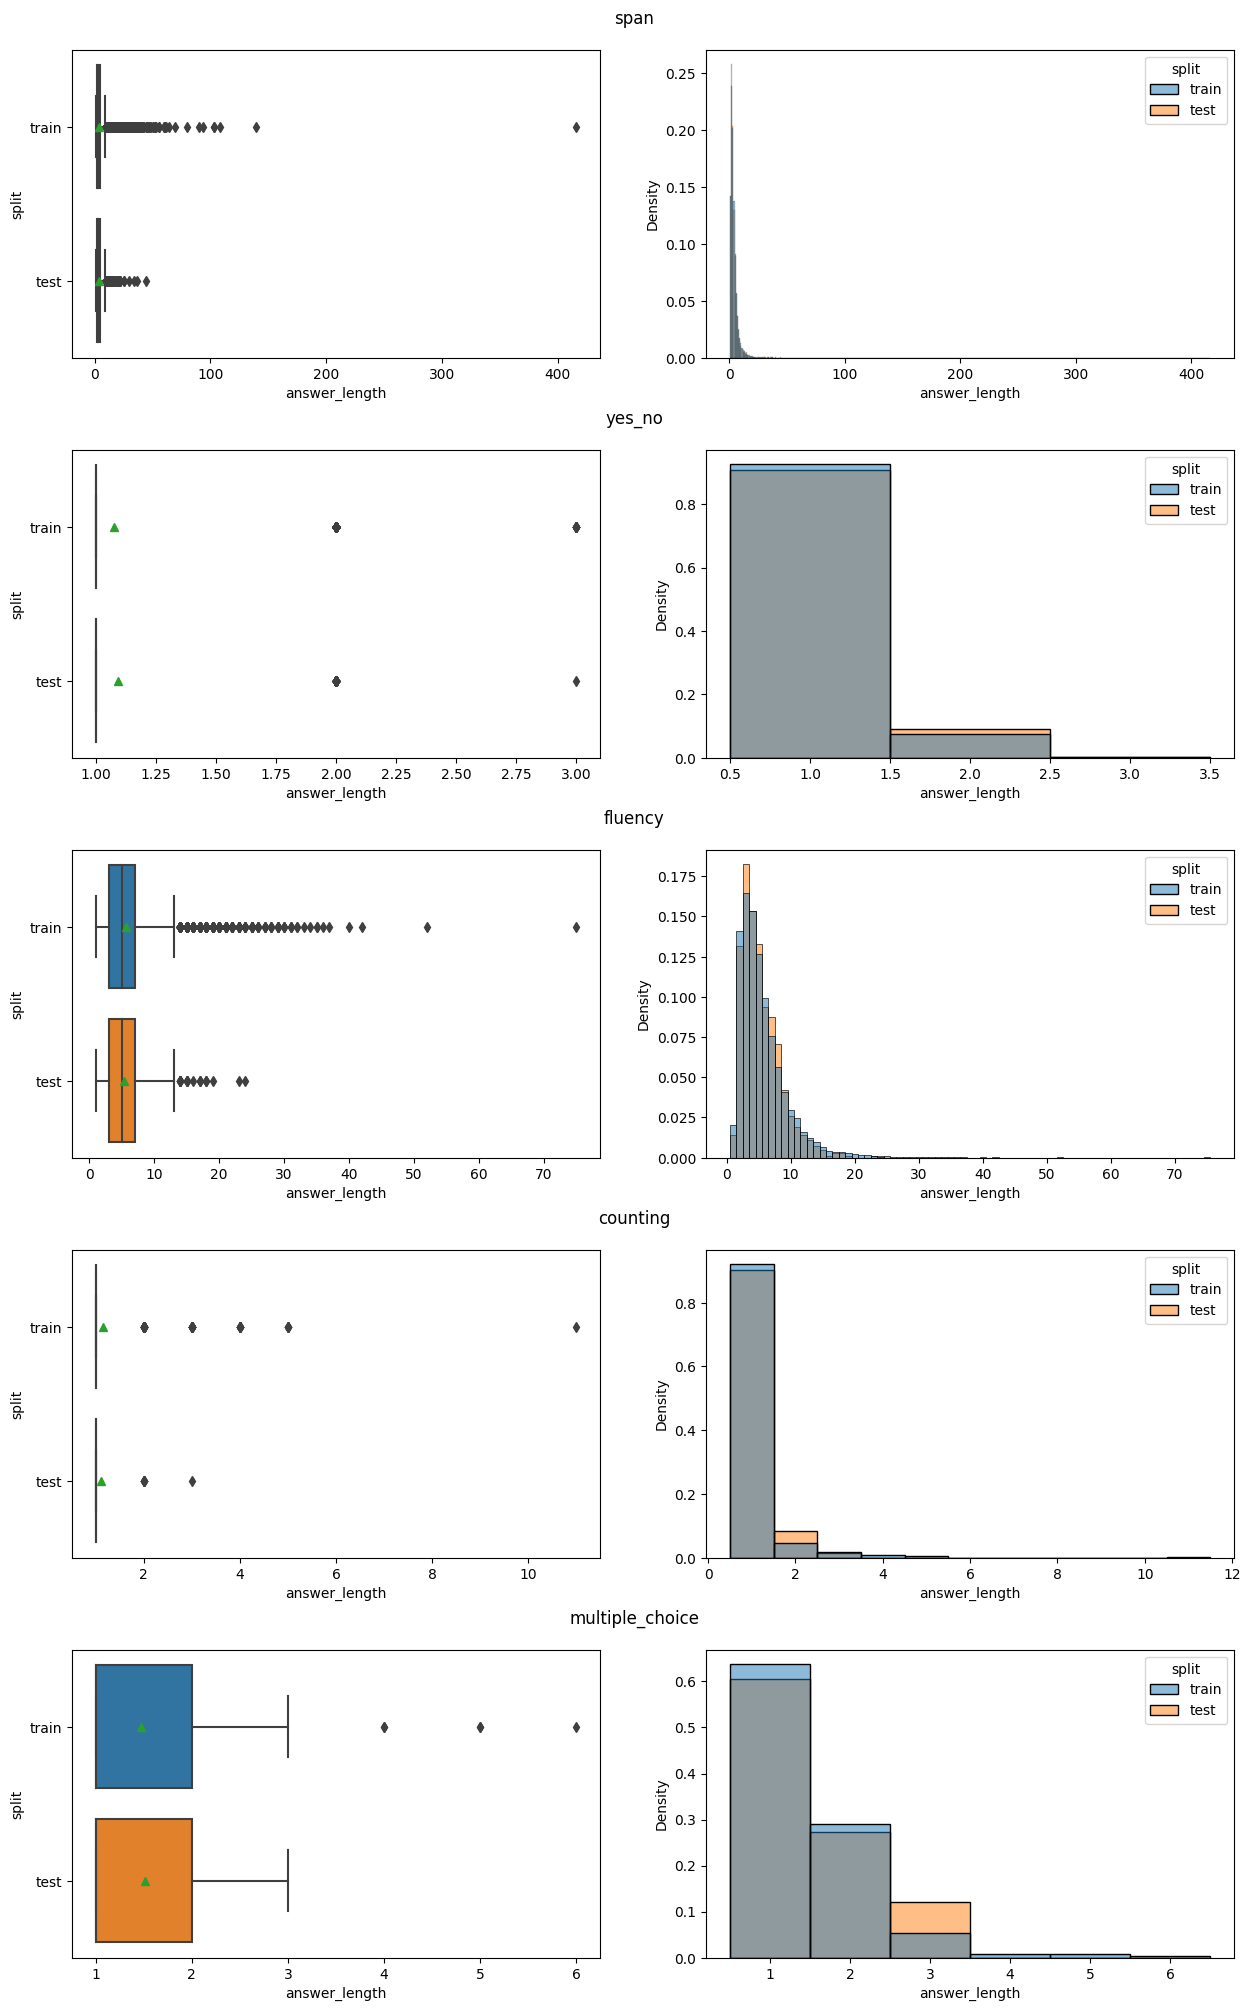

bert_tiny


answer_length                                           
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.112676  0.360527  1.0  1.0  1.0  1.0  \
                train         946.0  1.118393  0.558475  1.0  1.0  1.0  1.0   
fluency         test         1003.0  5.261216  3.174807  1.0  3.0  5.0  7.0   
                train       13760.0  5.508067  3.897807  1.0  3.0  5.0  7.0   
multiple_choice test           33.0  1.242424  0.501890  1.0  1.0  1.0  1.0   
                train         262.0  1.328244  0.742190  1.0  1.0  1.0  1.0   
span            test         5192.0  3.440485  2.936941  1.0  1.0  3.0  4.0   
                train       71348.0  3.628329  3.874219  1.0  2.0  3.0  4.0   
yes_no          test         1619.0  1.090797  0.287409  1.0  1.0  1.0  1.0   
                train       20970.0  1.073677  0.263251  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     3.0  
                train   11.0  
fluency         test    24.0  
                train   78.0  
multiple_choice test     3.0  
                train    7.0  
span            test    34.0  
                train  425.0  
yes_no          test     2.0  
                train    4.0

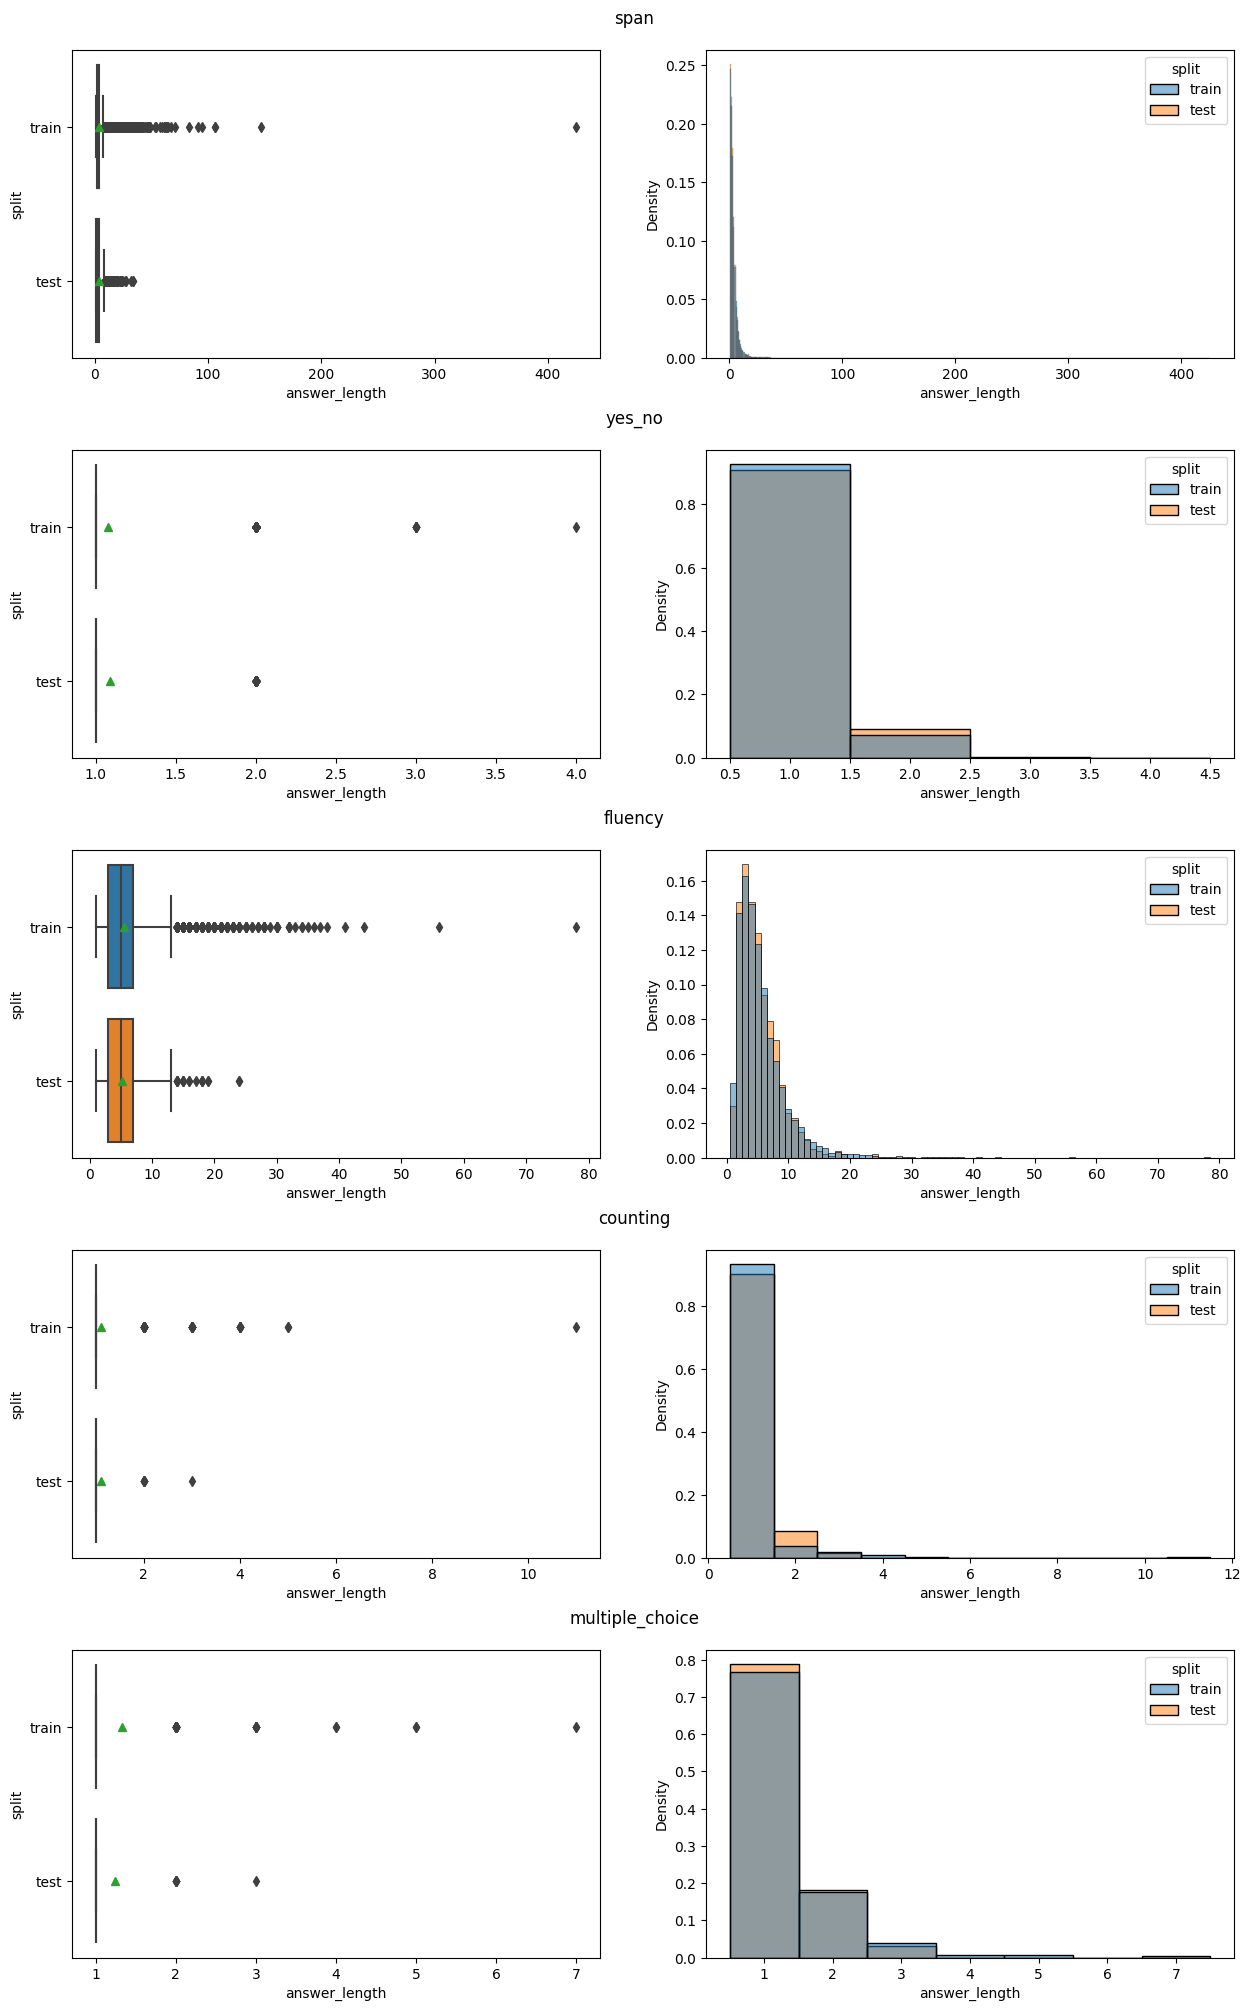

In [25]:
def plot_answer_length(dataset, split_fn=str.split, notes=None):
    length_col = "answer" + "_length"
    length = dataset["answer"].apply(split_fn).apply(len)
    dp = dataset[["answer_type", "split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby(["answer_type", "split"]).describe())

    answer_types = AnswerType.list(return_unknown=False)
    fig = plt.figure(figsize=(15, 4 * len(answer_types)))
    fig.suptitle(f"Answer length ({notes})", fontsize=16)

    subfigs = fig.subfigures(nrows=len(answer_types), ncols=1)
    for answer_type, subfig in zip(answer_types, subfigs):
        data = dp[dp["answer_type"] == answer_type]
        subfig.suptitle(answer_type)
        axes = subfig.subplots(1, 2)
        sns.boxplot(data=data,
                    x=length_col,
                    y="split",
                    showmeans=True,
                    ax=axes[0])
        sns.histplot(data,
                     x=length_col,
                     hue="split",
                     stat="density",
                     common_norm=False,
                     discrete=True,
                     ax=axes[1])
    plt.show()
    
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_answer_length(qa_dataset, split_fn=tokenize_fn, notes=checkpoint_name)

It's likely that very long answers need to be cleaned or to be removed. Let's start with `SPAN` answers.

In [26]:
def to_readable_question(question, answer, rationale, answer_type, turn=None):
    lines = []
    if turn is not None:
        lines.append(f'turn: {turn}')
    lines.append(f'Q\t\t{question} || {answer_type}')
    lines.append(f'A\t\t{answer} || {rationale}')

    return '\n'.join(lines)


def print_readable_questions(data: pd.DataFrame, show_turn=False):
    for _, row in data.iterrows():
        print("id:", row["id"])
        turn = row["turn"] if show_turn else None
        print(
            to_readable_question(row["question"],
                                 row["answer"],
                                 row["rationale"],
                                 row["answer_type"],
                                 turn=turn))
        print()

def show_long_answers(qa_dataset, answer_type, length):
    answers = qa_dataset[qa_dataset["answer_type"] == str(answer_type)].copy()
    answers["length"] = answers["answer"].str.split().apply(len)
    answers = answers.sort_values("length", ascending=False)
    long_answers = answers[answers["length"] > length]
    print(f"{answer_type} answers longer than {length} words:", len(long_answers))
    print_readable_questions(long_answers)

By manual inspection, we found that all the `span` answers longer than 37 words are useless, since they are just parts of the passage and do not answer their relative question.

In [27]:
show_long_answers(qa_dataset, answer_type = AnswerType.SPAN, length = 37)

span answers longer than 37 words: 18
id: 3y5140z9dxgb0yn2jvyfav6mf1tipy
Q		The last? || span
A		At the age of sixteen, I went on my first volunteer program in West Virginia to repair or build homes for poor families. When we arrived, we discovered that the family we were going to help was living in a trailer that was in poor condition, no bigger than two parking spaces. A group of people had been working on it for two weeks, but every time they finished one problem, another appeared. We soon decided that the only way was to build a new house. It was something unusual because normally our goal was to repair old homes. The family was pleased with their new house that was 20 by 30 feet with three bedrooms, a bath and a kitchen. On Tuesday of that week, I asked the family's three boys, Josh, Eric and Ryan, "What do you want for your new room?" Kids in the families we had helped usually wanted toys or posters, so we were surprised when Josh, the oldest boy said, "We just want beds." The bo

`Yes_no` answers with more than 1 words need to be cleaned.

In [28]:
show_long_answers(qa_dataset, answer_type = AnswerType.YES_NO, length = 1)

yes_no answers longer than 1 words: 6
id: 3i02618ya06g9pi2dcnttyux9jnupz
Q		Do they have a radio station? || yes_no
A		Yes :) || radio and television station

id: 3u5jl4wy5k9m10qekx6sa7i6ce3x4g
Q		Was Mrs Todgers a fancy dressing woman? || yes_no
A		. No. || . M. Todgers looked a little worn by cares of gravy and other such solicitudes arising out of her establishment, but displayed her usual earnestness and warmth of manner. 


id: 3ps7w85z8z2ghpn6wi1m2c8glett9x
Q		Did she visit other kids? || yes_no
A		. yes || . After that, she visited the hospital many times. Every time she visited, she brought toy bears

id: 3jcg6dtrv3q9h8c0wgidj2niarzqq6
Q		All of his life? || yes_no
A		. no || . Thurmond joined the Republican Party in the 1960s and ultimately turned away from his segregationist past. 

id: 3o7l7bfshep737ycahi4gj7i1qleiv
Q		Does everyone agree with the standard? || yes_no
A		. no || . Although not universally accepted, since then 

id: 3nkqq8o39y57ksfc83wyt4d8va6dua
Q		Was she ri

`Counting` answers with two words are ok. The examples below show also that some of the answers annotated as `counting` are rather `fluency`.

In [29]:
show_long_answers(qa_dataset, answer_type = AnswerType.COUNTING, length = 1)

counting answers longer than 1 words: 3
id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How old was he? || counting
A		Twenty Seven || age of 27

id: 37fmassaycr9w4ms0qgefb1xykpiby
Q		How many petty princely states were absorbed into Himachal? || counting
A		Twenty eight || 15 April 1948 as a result of integration of 28 petty princely states

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How many internationals goals did he have? || counting
A		Twenty Four ||  24 international goals 



Also `multiple_choice` answers with more than 1 word are ok.

In [30]:
show_long_answers(qa_dataset, answer_type = AnswerType.MULTIPLE_CHOICE, length = 1)

multiple_choice answers longer than 1 words: 34
id: 3lpw2n6lkt2cgf0jtxefvspgiwju50
Q		Did Sarah right about her and her brother's experience or some other people's? || multiple_choice
A		About her and her brother's ||  Sarah has now written a best-selling book about their experience, calledAnyone Can Do It ! 

id: 3olf68ytn91k33fat4axh34z0jjfay
Q		Does the program air at the end of the week or the front of the week? || multiple_choice
A		front of the week || Monday night

id: 3m0nz3jdp1yt2eutzkdnck4vjx95zc
Q		did it take her longer to hike up alone or down with the dog? || multiple_choice
A		Down with the dog. || The trip up had taken 30 minutes while going back down took twice that.

id: 3k3r2qnk8b3vh22vwnrw78ui4spu9e
Q		was instructed to go, or told to think about it? || multiple_choice
A		To think about it. ||  I know she said that she would sooner that you were present than all her English friends together. However, you can think about it.

id: 340ugxu9dy1te9fyzowszqjfvk3vuq
Q		Was

Let's inspect the question-passage length, i.e. the input length when there is no history.

question-passage_length                                               
                        count        mean        std    min    25%    50%   
split                                                                       
test                   7918.0  270.235034  72.681189  125.0  231.0  267.0  \
train                107286.0  276.325905  63.047269   72.0  252.0  272.0   

                      
         75%     max  
split                 
test   299.0   812.0  
train  299.0  1042.0

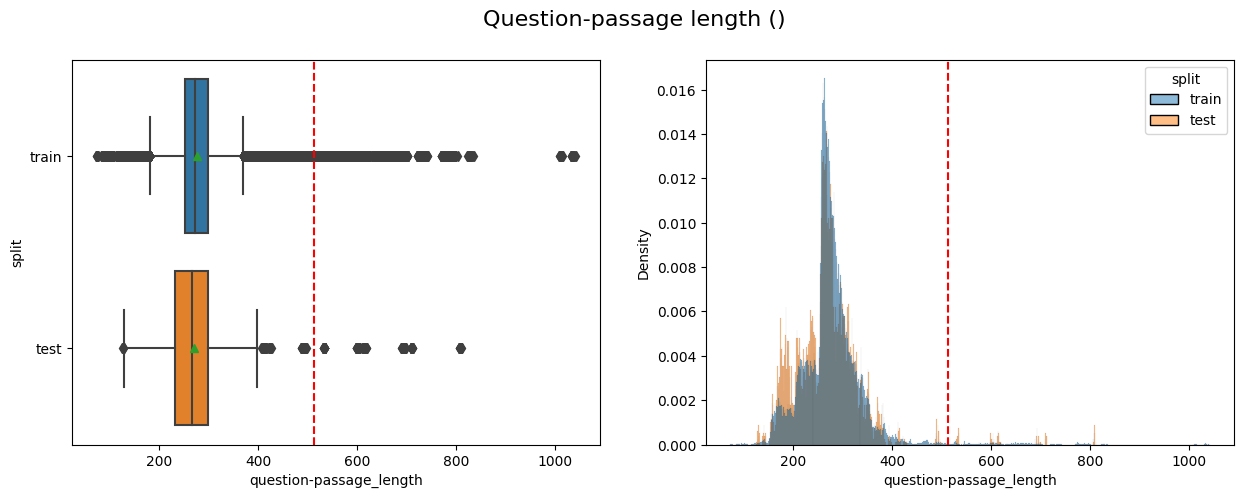

distil_roberta


question-passage_length                                                
                        count        mean         std    min    25%    50%   
split                                                                        
test                   7918.0  356.997853  100.797187  149.0  294.0  362.0  \
train                107286.0  368.918666   86.822364   94.0  329.0  371.0   

                      
         75%     max  
split                 
test   407.0  1055.0  
train  408.0  1386.0

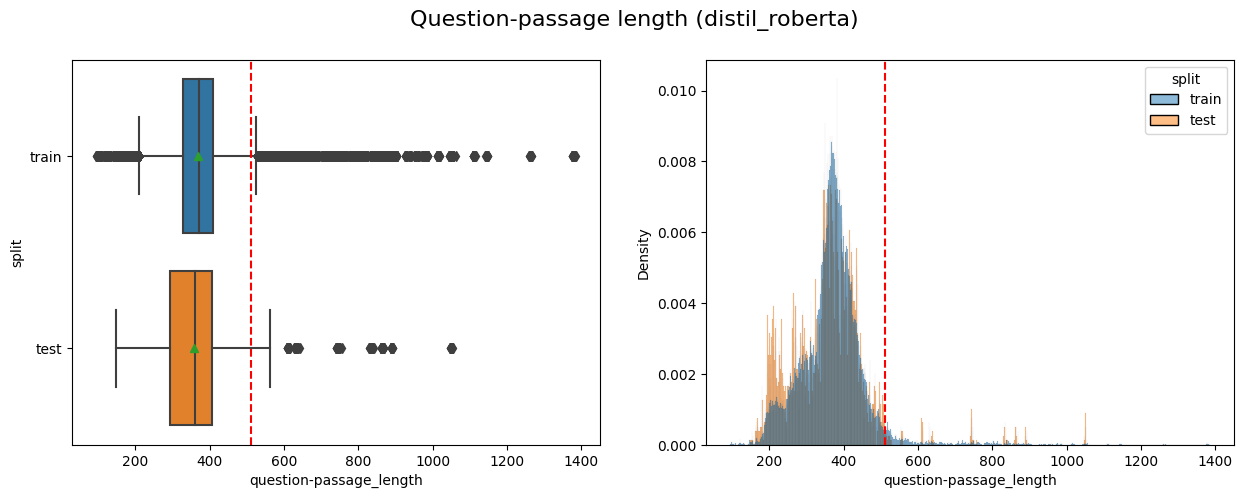

bert_tiny


question-passage_length                                               
                        count        mean        std    min    25%    50%   
split                                                                       
test                   7918.0  346.882925  97.682956  151.0  289.0  349.0  \
train                107286.0  357.272580  83.424987   92.0  318.0  356.0   

                      
         75%     max  
split                 
test   390.0  1047.0  
train  393.0  1335.0

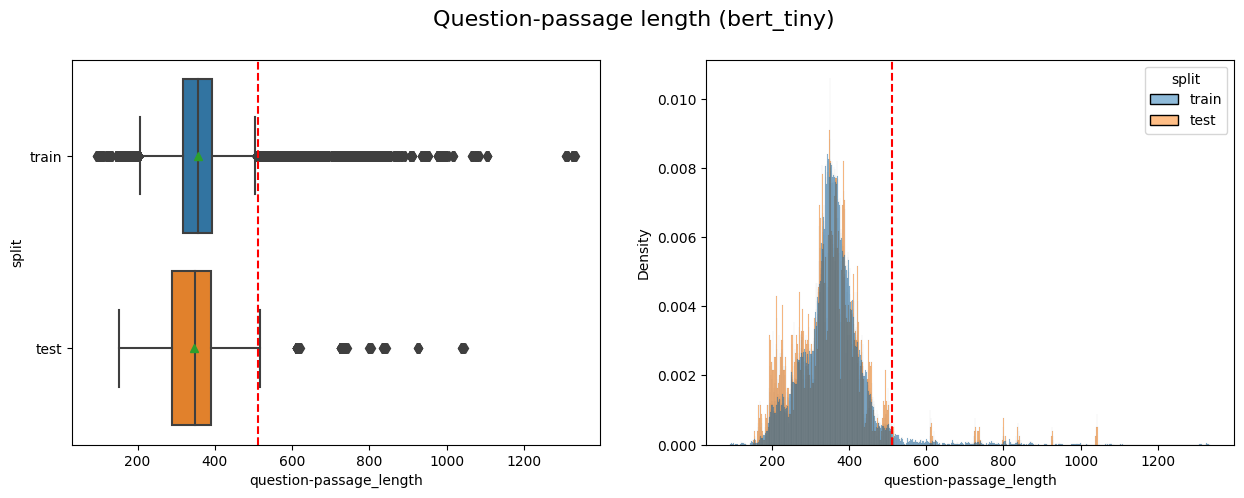

In [31]:
qa_dataset["input"] = qa_dataset["question"] + " " + qa_dataset["story"]
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="input",
                column_name="question-passage",
                split_fn=tokenize_fn,
                notes=checkpoint_name,
                max_length=512)

Let's analyze the question-answer pair lengths, useful to have information on the history length.

question-answer pair_length                                            
                            count      mean       std  min  25%  50%   75%   
split                                                                        
test                       7918.0  8.000253  3.283074  2.0  6.0  7.0  10.0  \
train                    107286.0  8.132468  3.781931  2.0  6.0  7.0  10.0   

              
         max  
split         
test    28.0  
train  355.0

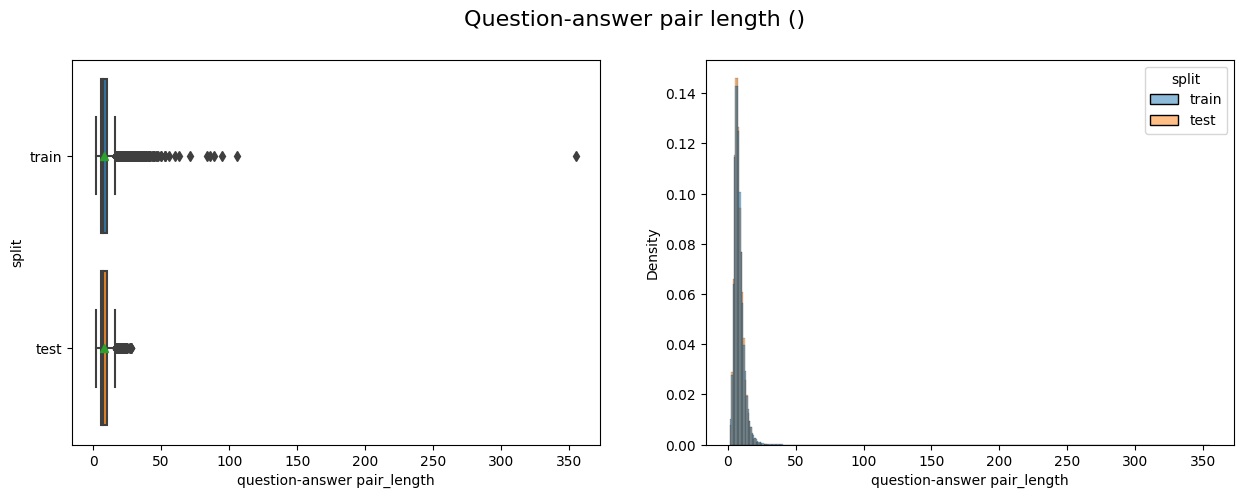

distil_roberta


question-answer pair_length                                             
                            count       mean       std  min  25%  50%   75%   
split                                                                         
test                       7918.0   9.881662  3.888559  2.0  7.0  9.0  12.0  \
train                    107286.0  10.092426  4.502837  2.0  7.0  9.0  12.0   

              
         max  
split         
test    49.0  
train  419.0

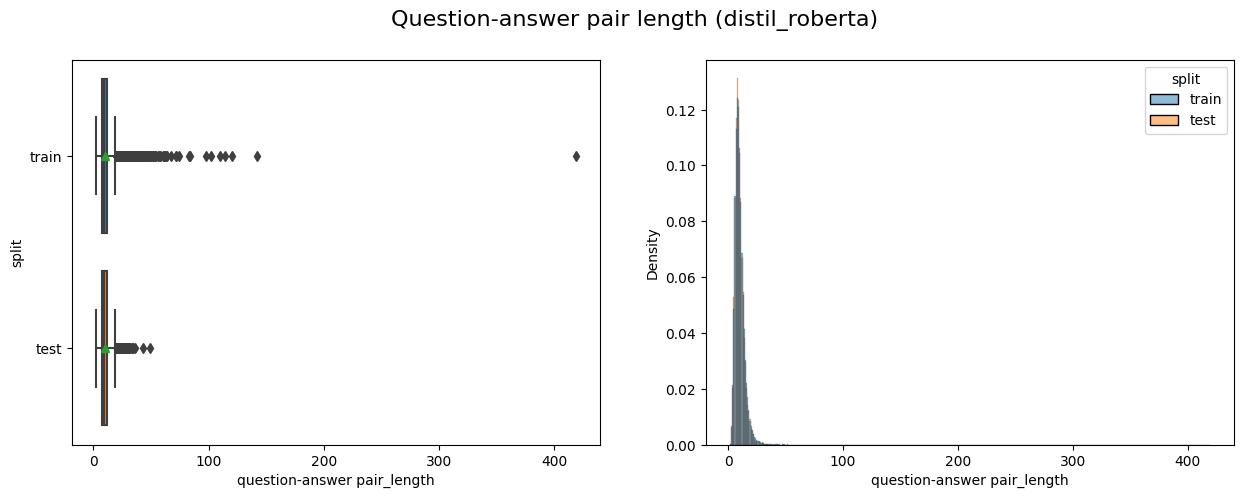

bert_tiny


question-answer pair_length                                             
                            count       mean       std  min  25%  50%   75%   
split                                                                         
test                       7918.0   9.849836  3.903834  2.0  7.0  9.0  12.0  \
train                    107286.0  10.060847  4.540767  2.0  7.0  9.0  12.0   

              
         max  
split         
test    40.0  
train  428.0

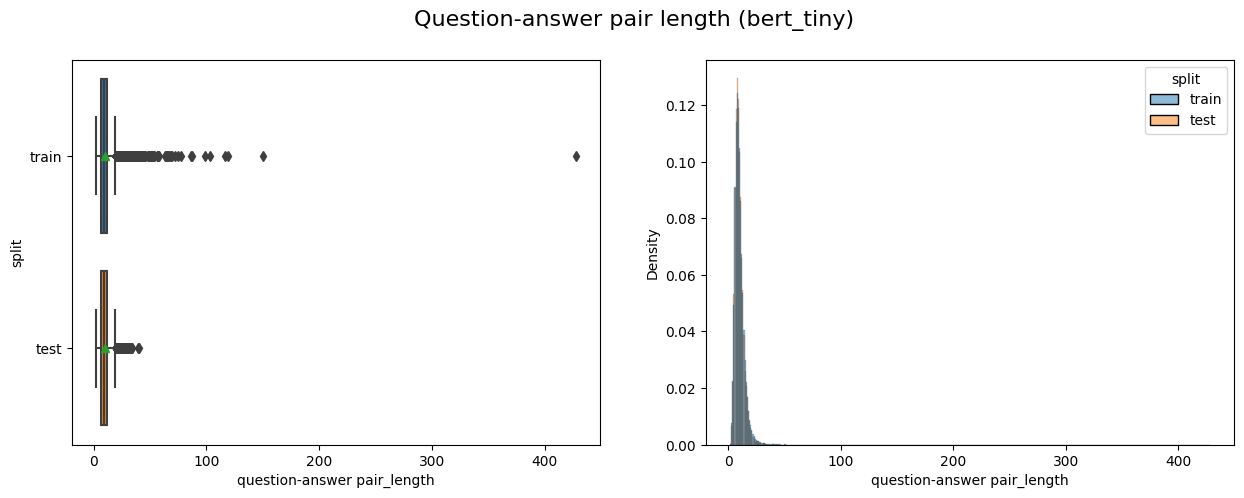

In [32]:
qa_dataset["qa"] = qa_dataset["question"] + " " + qa_dataset["answer"]
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="qa",
                column_name="question-answer pair",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

rationale_length                                                
                 count      mean       std  min  25%  50%   75%    max
split                                                                 
test            7918.0  9.133114  8.820682  1.0  4.0  7.0  12.0  268.0
train         107286.0  9.241252  9.257729  1.0  4.0  7.0  12.0  353.0

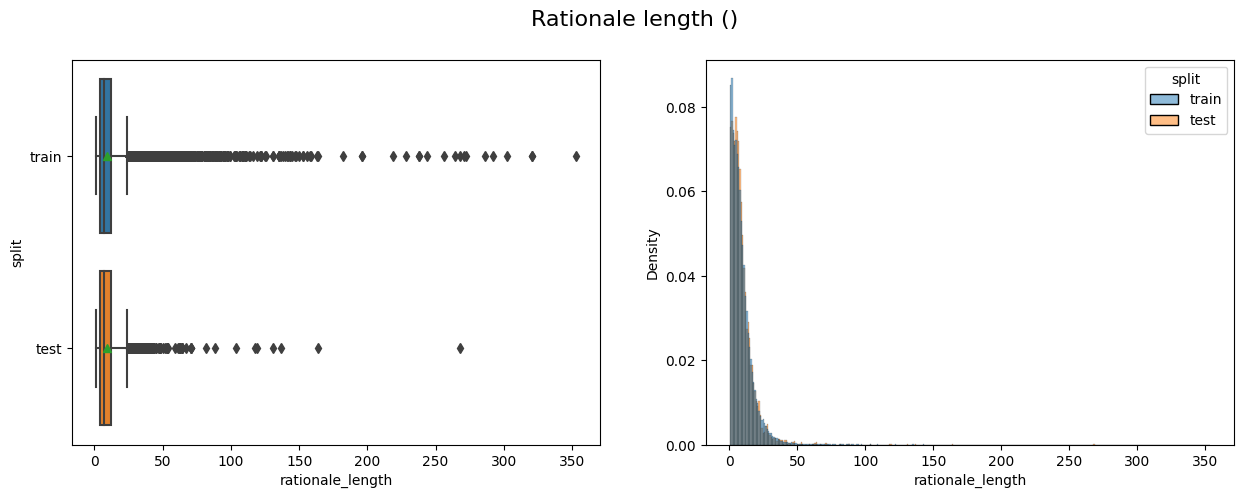

distil_roberta


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.755620  11.689437  1.0  5.0  9.0  15.0  414.0
train         107286.0  12.007997  12.147238  1.0  5.0  9.0  15.0  461.0

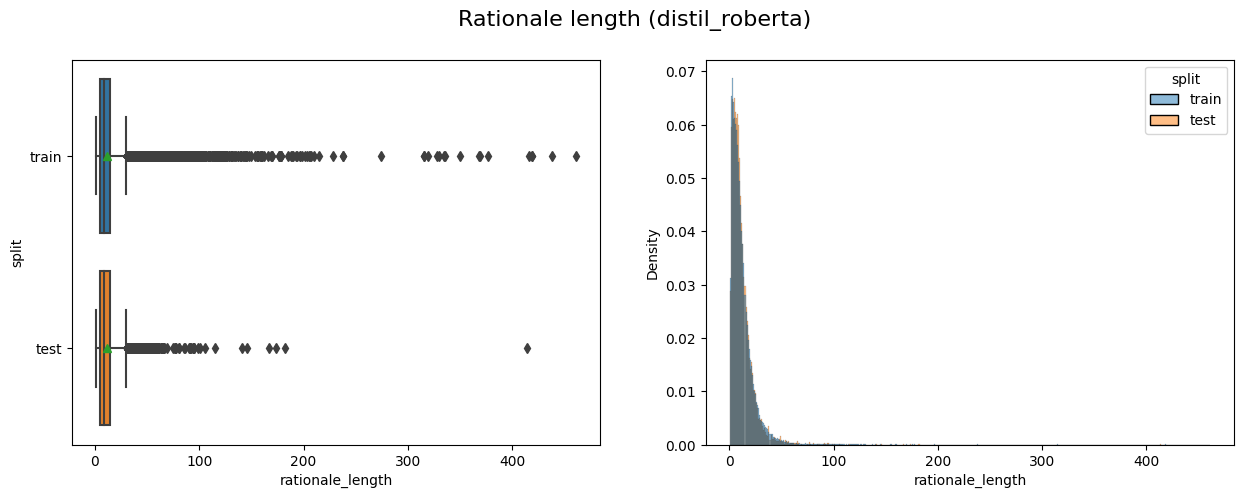

bert_tiny


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.437737  11.621558  1.0  5.0  9.0  15.0  402.0
train         107286.0  11.663283  12.094999  1.0  4.0  9.0  15.0  436.0

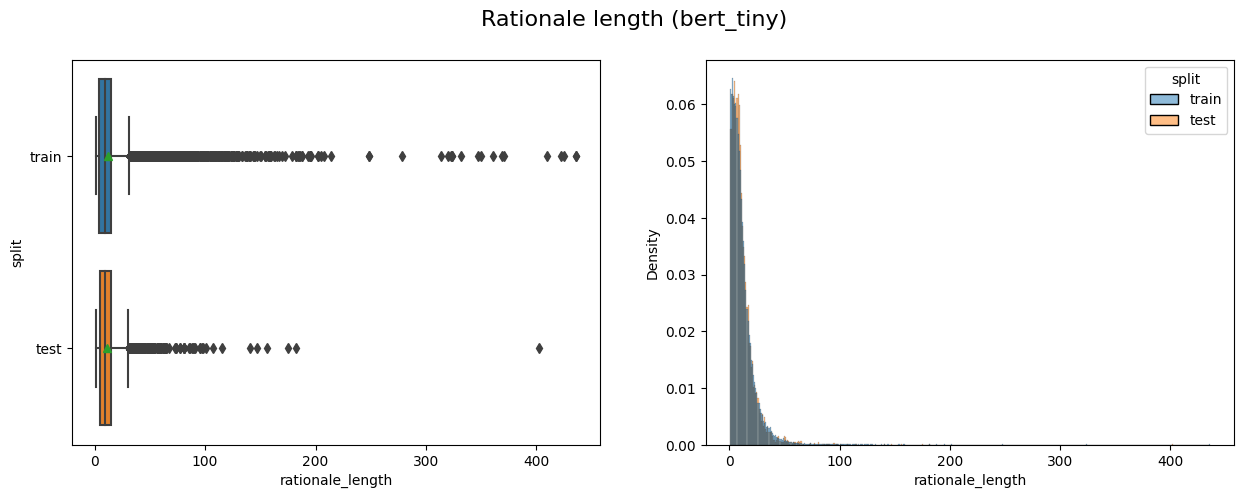

In [33]:
for checkpoint_name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="rationale",
                split_fn=tokenize_fn,
                notes=checkpoint_name)

Most of the very lengthy rationales are a consequence of poor workmanship.

In [34]:
def show_long_rationales(qa_dataset, length):
    rationales = qa_dataset.copy()
    rationales["length"] = rationales["rationale"].str.split().apply(len)
    rationales = rationales.sort_values("length", ascending=False)
    long_rationales = rationales[rationales["length"] > length]
    print("Number of questions with very long rationale:", len(long_rationales))
    print()
    print_readable_questions(long_rationales)
    
show_long_rationales(qa_dataset, length=150)

Number of questions with very long rationale: 28

id: 3y5140z9dxgb0yn2jvyfav6mf1tipy
Q		The last? || span
A		At the age of sixteen, I went on my first volunteer program in West Virginia to repair or build homes for poor families. When we arrived, we discovered that the family we were going to help was living in a trailer that was in poor condition, no bigger than two parking spaces. A group of people had been working on it for two weeks, but every time they finished one problem, another appeared. We soon decided that the only way was to build a new house. It was something unusual because normally our goal was to repair old homes. The family was pleased with their new house that was 20 by 30 feet with three bedrooms, a bath and a kitchen. On Tuesday of that week, I asked the family's three boys, Josh, Eric and Ryan, "What do you want for your new room?" Kids in the families we had helped usually wanted toys or posters, so we were surprised when Josh, the oldest boy said, "We just want b

In [35]:
example = qa_dataset[qa_dataset["rationale"] == qa_dataset["story"]]
print("Number of questions with rationale equal to the whole passage:",
      len(example))
print()
print_readable_questions(example)

Number of questions with rationale equal to the whole passage: 11

id: 3vj40nv2qinjocrcy7k4z235f4yot6
Q		DId someone want to put olives on it? || yes_no
A		No. || The children's father wanted to know what every one wanted on their pizza. Andy wanted a strawberry on his pizza. Father thought that was funny. Father asked if anyone wanted chicken on the pizza. Sue did not want chicken. Andy wanted chicken. Dan did not want chicken, but their father wanted to get chicken on the pizza. Dan asked if they could have mushrooms on the pizza. Father did not like mushrooms. Andy and Sue wanted to have mushrooms, so their father had them put mushrooms on the pizza. Sue wanted to have green onions on the pizza. Father also wanted green onions. Dan and Andy did not like green onions, so they did not get green onions on the pizza. Father wanted to order thin crust pizza. Dan thought that thin crust pizza had the taste of an old shoe. Sue thought Dan was wrong. Sue wanted thin crust pizza also. Andy w

Upon further analysis of the corpus, we observed instances where words at the beginning or at the end of the rationale are truncated. Therefore, we have to fix them if we intend to use the rationale to train the network.

In [36]:
def print_rationales(data: pd.DataFrame):
    for i, row in data.iterrows():
        print("id:", row["id"], "split:", row["split"])
        print("turn:", row["turn"])
        print("R:", row["rationale"], "|", row["span_start"], "-",
              row["span_end"])
        print("=" * 100)


def is_rationale_truncated(passage, span_start, span_end):
    if span_start > 0 and passage[span_start].isalnum() and passage[
            span_start - 1].isalnum():
        return True

    if span_end < len(passage) and passage[
            span_end - 1].isalnum() and passage[span_end].isalnum():
        return True

    return False


example = qa_dataset[qa_dataset.apply(lambda row: is_rationale_truncated(
    row["story"], row["span_start"], row["span_end"]),
                                      axis=1)]
print("Number of rationales with errors:", len(example), "/", len(qa_dataset))
print()
print_rationales(example)

Number of rationales with errors: 5572 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R: he Vatican Library is a research library | 454 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R: Scholars have traditionally divided the history of the library into five period | 1048 - 1127
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 11
R: atican Secret Archives were separated from the library at the beginning of the 17th century; | 917 - 1009
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 16
R: hotocopies for private study of pages from books published between 1801 and 1990 | 644 - 724
id: 3bdcf01ogxu7zdn9vlrbf2rqzwplyf split: train
turn: 11
R: the need of a helper, of a friend, of a champio | 751 - 798
id: 3urfvvm165iantk80llvkwwbjs7uzh split: train
turn: 3
R:  Valentina was very pale, and round her eyes there were dark circles that told of sleeplessness, and as she bowed her head in prayer, her ladies observed that tears were falling on the ill

In order to solve the issue, we have to:
1. remove any leading or trailing non alphanumeric character (i.e. spaces, punctuation, etc.) from the rationale.
2. compute new `span_start` and `span_end` indices by considering the entire words.

In [37]:
#1. removing leading and trailing non alphanumeric chars
example = " Despite a common background, the groups' views on religious toleration were mixe."
print("Before:", example)
print("After:", strip_non_alphanumeric_chars(example))

Before:  Despite a common background, the groups' views on religious toleration were mixe.
After: Despite a common background, the groups' views on religious toleration were mixe


In [38]:
qa_dataset_fixed = qa_dataset.copy()
qa_dataset_fixed["rationale"] = qa_dataset_fixed["rationale"].apply(
    strip_non_alphanumeric_chars)
n_affected_rationales = np.count_nonzero(
    qa_dataset_fixed["rationale"] != qa_dataset["rationale"])
print("Number of affected rationales:", n_affected_rationales, "/",
      len(qa_dataset))


Number of affected rationales: 55649 / 115204


In [39]:
#2. compute span_start and span_end indices by considering the entire words.
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = "e Vatican Library is a research lib"
span_start, span_end = find_span(passage, rationale)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "The Vatican Library is a research library"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

print()

passage = " Mandi Marie Utash posted Friday to a GoFundMe.com page [...]\nMandi Marie Utash\twrote that her father doesn't seem to know what happened"
rationale = "andi Marie Utas"
span_start, span_end = find_span(passage,
                                 rationale,
                                 span_start=63,
                                 span_end=78)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "Mandi Marie Utash"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-): e Vatican Library is a research lib
R (+): The Vatican Library is a research library | 1 - 42

P:  Mandi Marie Utash posted Friday to a GoFundMe.com page [...]
Mandi Marie Utash	wrote that her father doesn't seem to know what happened
R (-): andi Marie Utas
R (+): Mandi Marie Utash | 62 - 79


In [40]:
# Fix rationale by applying (1) and (2)
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = " e Vatican Library is a research library for history,  "
fixed_rationale, span_start, span_end = fix_rationale(passage, rationale, 1,
                                                      100)

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)
assert fixed_rationale == "The Vatican Library is a research library for history"

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-):  e Vatican Library is a research library for history,  
R (+): The Vatican Library is a research library for history | 1 - 54


In [41]:
def _fix_rationale(row):
    fixed_rationale, span_start, span_end = fix_rationale(
        row["story"], row["rationale"], row["span_start"], row["span_end"])

    row["rationale"] = fixed_rationale
    row["span_start"] = span_start
    row["span_end"] = span_end

    return row


qa_dataset_fixed = qa_dataset.apply(_fix_rationale, axis=1)
diff_start = qa_dataset_fixed["span_start"] != qa_dataset["span_start"]
diff_end = qa_dataset_fixed["span_end"] != qa_dataset["span_end"]
diff_rationale = qa_dataset_fixed["rationale"] != qa_dataset["rationale"]

assert np.all((diff_start | diff_end) == diff_rationale)

example = qa_dataset_fixed[diff_rationale]
print("Number of fixed rationales:", len(example), "/", len(qa_dataset))
print()
for i, row in example.iloc[:100].iterrows():
    old_row = qa_dataset[(qa_dataset["id"] == row["id"])
                         & (qa_dataset["turn"] == row["turn"])]
    assert len(old_row) == 1
    old_row = old_row.iloc[0]

    print("id:", row["id"], "split:", row["split"])
    print("turn:", row["turn"])
    print("R (-):", old_row["rationale"], "|", old_row["span_start"], "-",
          old_row["span_end"])
    print("R (+):", row["rationale"], "|", row["span_start"], "-",
          row["span_end"])
    print("=" * 100)

qa_dataset = qa_dataset_fixed
del qa_dataset_fixed

Number of fixed rationales: 58992 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R (-): he Vatican Library is a research library | 454 - 494
R (+): The Vatican Library is a research library | 453 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R (-): Scholars have traditionally divided the history of the library into five period | 1048 - 1127
R (+): Scholars have traditionally divided the history of the library into five periods | 1048 - 1128
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 8
R (-): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat,  | 4 - 94
R (+): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat | 4 - 92
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 9
R (-): is the library of the Holy See, located in Vatican City. | 94 - 150
R (+): is the library of the Holy See, located in Vatican City | 94 - 149
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train

The type of answers are equally distributed across datasets.

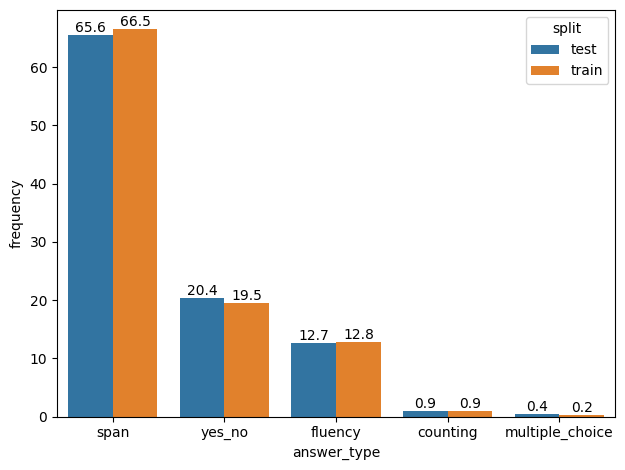

In [42]:
plot_answer_type_distribution(qa_dataset)

In [43]:
for answer_type in AnswerType.list(return_unknown=False):
    example = qa_dataset[qa_dataset["answer_type"] == answer_type].sample(3)
    print(answer_type)
    print()
    print_readable_questions(example)
    print("=" * 100)

span

id: 3yhh42uu5bfa2irondg2nax6np10lw
Q		Who was running around? || span
A		Fido. || Fido was running around

id: 3r5f3lqfv2kfao0b4z9mlq4m17moz3
Q		what type of dog was Rob? || span
A		partly bloodhound, || It was supposed that Rob was partly bloodhound

id: 3dpnqgw4llf9il6ijax2au5mfap64g
Q		What bridge? || span
A		George Washington Bridge || New York's George Washington Bridge

yes_no

id: 39u1bhvtdlru2nyqf90cbz5ulfbt3u
Q		Are presidents constantly being evaluated by the media? || yes_no
A		yes || Constant scrutiny from the media means the president essentially works inside glass walls

id: 3tayzsbpll8425psm9hhik4gdcjs23
Q		What about species? || yes_no
A		yes || This can refer to genetic variation, ecosystem variation, or species variation (number of species) within an area, biome, or planet

id: 308q0pevb8dq8b7v262io567avq9i5
Q		Do they have a language? || yes_no
A		Yes || The Serbian language is official in Serbia, co

fluency

id: 3p1l2b7ad1pv5zj7pyiddbtollwolb
Q		Where were th

In [44]:
del qa_dataset

## Remove long answers from training set

In the Data Inspection section we found that long `span` answers are simply wrong. Therefore, we remove it from the training set before going on.

In [45]:
dataset = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
dataset

DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 7193
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})

In [46]:
def remove_long_span_answers(example, max_length):
    questions = []
    answers = []
    for question_item, answer_item in zip(example["questions"],
                                          example["answers"]):
        
        if question_item["answer_type"] == str(AnswerType.SPAN):
            answer = answer_item["input_text"]
            length = len(answer.split())
            if length > max_length:
                continue

        questions.append(question_item)
        answers.append(answer_item)

    qa_length = len(questions)
    return {
        'questions': questions,
        'answers': answers,
        'qa_length': qa_length
    }


print("Removing long span answers...")
dataset["train"] = dataset["train"].map(remove_long_span_answers, fn_kwargs={"max_length": CONFIG.span_max_length})
print("Done!")

filtered_dataset = remove_examples_with_no_qa(dataset)
filtered_dataset.save_to_disk(CONFIG.dataset.filtered_dir)

del dataset
del filtered_dataset

Removing long span answers...


Map:   0%|          | 0/7193 [00:00<?, ? examples/s]

Done!


Filter:   0%|          | 0/7193 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Examples with no qa pairs: {'train': 1, 'test': 0}


answers                                              story questions   
0      []  CHAPTER XXXII \n\n"You are very smart, Ernesti...        []  \

                                                name   
0  data/gutenberg/txt/Edward Phillips Oppenheim__...  \

                                            filename     source   
0  data/gutenberg/txt/Edward Phillips Oppenheim__...  gutenberg  \

                               id  qa_length  last_turn  
0  3i33ic7zwf20293y59vqxkaargp2ae          0          1


Filtering out examples with no qa pairs...


Filter:   0%|          | 0/7193 [00:00<?, ? examples/s]

Filter:   0%|          | 0/500 [00:00<?, ? examples/s]

Done!

Number of examples: {'train': 7192, 'test': 500}


Saving the dataset (0/1 shards):   0%|          | 0/7192 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

## Input preparation

In order to train our models, we have to prepare the inputs properly. First of all, we explode the QA pairs so that to have one record for each question. Then, we preprocess the texts. In particular:
1. we fix the rationales by removing leading and trailing non alphanumeric chars, and by restoring truncated words
2. we remove multiple spaces from the texts of our inputs (changing the rationale spans accordingly)
3. we clean the answers by removing leading and trailing non alphanumeric chars

In [47]:
dataset = datasets.DatasetDict.load_from_disk(CONFIG.dataset.filtered_dir)
train_dataset = dataset["train"].select(range(10))

preprocessing = CoQADatasetPreprocessing()
train_dataset = train_dataset.map(
    batched_function(preprocessing.explode_questions, scalar_output=False),
    batched=True,
    remove_columns=dataset["train"].column_names,
)
train_dataset = train_dataset.rename_column("story", "passage")
train_dataset = train_dataset.remove_columns(["questions", "answers", "qa_length", "last_turn"])
train_dataset = train_dataset.map(
    batched_function(preprocessing.preprocess_texts), batched=True
)

print(train_dataset)
train_dataset[:5]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Dataset({
    features: ['passage', 'name', 'filename', 'source', 'id', 'id_', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
    num_rows: 150
})


{'passage': ['The Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat, is the library of the Holy See, located in Vatican City. Formally established in 1475 , although it is much older, it is one of the oldest libraries in the world and contains one of the most significant collections of historical texts. It has 75,000 codices from throughout history, as well as 1.1 million printed books, which include some 8,500 incunabula. The Vatican Library is a research library for history, law, philosophy, science and theology. The Vatican Library is open to anyone who can document their qualifications and research needs. Photocopies for private study of pages from books published between 1801 and 1990 can be requested in person or by mail. In March 2014, the Vatican Library began an initial four-year project of digitising its collection of manuscripts, to be made available online. The Vatican Secret Archives were separated from the library at the beginning of

### No History

Given a passage $P$ and a question $Q$, the corresponding input will be obtained by concatenating $P$ to $Q$ separated by a model-dependant separator.
- DistilRoBERTa input: `<s>Q</s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Q [SEP] P [SEP] [PAD] ... [PAD]`

Here, we have to address two problems:
- the input may exceed the `max_sequence_length` of the model (i.e. 512 tokens). In such case, we truncate only the passage $P$.
- if we want to use the rationale, we need to map the rational span chars indices to the corresponding tokens indices.

Truncating the passage leads to another problem: the rationale (hence, the answer) may not be contained in the truncated passage. A way to handle such problem is by considering several "windows" of the passage for each QA pair.

In [48]:
def process_data_to_model_inputs(tokenizer, data, add_history=False):
    preprocessing = CoQADatasetPreprocessing(tokenizer,
                                             use_window=True,
                                             encoder_max_length=300)
    return preprocessing.process_data_to_model_inputs(data,
                                                      add_history=add_history)


def prepare_and_show_inputs(checkpoint, data, add_history=False):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    inputs = process_data_to_model_inputs(tokenizer,
                                          data,
                                          add_history=add_history)
    show_inputs(tokenizer, data, inputs)

In [49]:
indices = np.random.choice(train_dataset.num_rows, size=3)
target = train_dataset.select(indices)[:]

for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Input examples for:", checkpoint_name)
    print()
    prepare_and_show_inputs(checkpoint, target)
    print("=" * 30)

Input examples for: distil_roberta

input_ids                  : [[0, 6209, 24, 41, 505, 343, 11, 24, 18, 247, 116, 2, 2, 17781, 47, 655, 57, 7, 103, 380, 1947, 11, 5, 232, 116, 20, 335, 874, 40, 28, 7163, 7, 47, 4, 22911, 286, 171, 11505, 6, 22911, 21, 80, 1947, 6, 19, 11504, 102, 15, 5, 3072, 526, 9, 5, 4908, 2503, 13345, 8, 221, 990, 15, 5, 3017, 526, 4, 22911, 1059, 65, 343, 11, 504, 4956, 6, 8, 24, 34, 57, 5, 812, 343, 9, 11279, 13, 59, 42991, 107, 479, 20, 1956, 9, 22911, 16, 59, 130, 153, 6, 8, 5, 343, 16, 10, 182, 1406, 317, 13, 6349, 4, 18394, 101, 7, 185, 4293, 9668, 552, 5, 2503, 13345, 4, 22911, 16, 67, 684, 13, 63, 3571, 363, 5367, 4, 20, 275, 86, 7, 825, 16, 1035, 187, 22911, 16, 182, 2569, 11, 2608, 4, 1287, 1422, 1287, 1422, 21, 4790, 11, 601, 6668, 4, 590, 155, 4, 245, 153, 82, 24, 16, 122, 5, 934, 343, 11, 886, 8, 5, 200, 1154, 343, 11, 5, 315, 532, 4, 85, 16, 3395, 13, 63, 2297, 15316, 6, 63, 1569, 2690, 6, 8, 63, 5278, 2154, 4, 520, 5, 343, 16, 269, 5278, 2154, 4740

### History

Given a passage $P$, a question $Q_i$ and an history $H=\{(Q_j, A_j)\}_{j=1..i-1}$, the corresponding input will be obtained as the concatenation of $H$, $Q$ and $P$ separated by a model-dependant separator, as follows:
- DistilRoBERTa input: `<s>Q1</s>A1</s>...Qi-1</s>Ai-1</s>Qi</s></s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Q1 [SEP] A1 [SEP] ... Qi-1 [SEP] Ai-1 [SEP] Qi [SEP] P [SEP] [PAD] ... [PAD]`

By adding the history, the input very often exceed the `max_sequence_length` of the model (i.e. 512 tokens). From the analysis above, we know that each QA pair requires around 10 tokens. Hence, an history of $[3..5]$ passes is a good trade-off between the context and the needed space.

In [50]:
indices = np.random.choice(train_dataset.num_rows, size=3)
target = train_dataset.select(indices)[:]
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Input examples for:", checkpoint_name)
    print()
    prepare_and_show_inputs(checkpoint, target, add_history=True)
    print("=" * 30)

Input examples for: distil_roberta

input_ids                  : [[0, 2264, 16, 5, 2147, 101, 89, 116, 2, 16864, 8, 3279, 2, 2264, 16, 24, 593, 7, 116, 2, 37711, 1245, 2, 6179, 171, 82, 697, 11, 15643, 24309, 116, 2, 176, 4, 246, 153, 2, 6209, 24, 6162, 7, 697, 89, 116, 2, 2362, 2, 8275, 82, 6573, 7, 907, 383, 11, 3523, 3532, 116, 2, 2, 17781, 47, 655, 57, 7, 103, 380, 1947, 11, 5, 232, 116, 20, 335, 874, 40, 28, 7163, 7, 47, 4, 22911, 286, 171, 11505, 6, 22911, 21, 80, 1947, 6, 19, 11504, 102, 15, 5, 3072, 526, 9, 5, 4908, 2503, 13345, 8, 221, 990, 15, 5, 3017, 526, 4, 22911, 1059, 65, 343, 11, 504, 4956, 6, 8, 24, 34, 57, 5, 812, 343, 9, 11279, 13, 59, 42991, 107, 4, 20, 1956, 9, 22911, 16, 59, 130, 153, 6, 8, 5, 343, 16, 10, 182, 1406, 317, 13, 6349, 4, 18394, 101, 7, 185, 4293, 9668, 552, 5, 2503, 13345, 4, 22911, 16, 67, 684, 13, 63, 3571, 363, 5367, 4, 20, 275, 86, 7, 825, 16, 1035, 187, 22911, 16, 182, 2569, 11, 2608, 4, 1287, 1422, 1287, 1422, 21, 4790, 11, 601, 6668, 4, 590, 1

In [51]:
del dataset
del train_dataset
del target

# [Task 2] Train, test and validation split

In [53]:
dataset = datasets.load_from_disk(CONFIG.dataset.filtered_dir)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 7192
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


In [54]:
train_data = dataset["train"]
test_data = dataset["test"]
splitted_dataset = train_data.train_test_split(train_size=0.8, seed=42)
splitted_dataset["validation"] = splitted_dataset.pop("test")
splitted_dataset["test"] = test_data

print(splitted_dataset)

splitted_dataset.save_to_disk(CONFIG.dataset.splitted_dir)
del train_data
del test_data

DatasetDict({
    train: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 5753
    })
    validation: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 1439
    })
    test: Dataset({
        features: ['answers', 'story', 'questions', 'name', 'filename', 'source', 'id', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


Saving the dataset (0/1 shards):   0%|          | 0/5753 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1439 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

Before proceeding with the next task, we explode the questions and apply the preprocessing as discussed in the Input Preparation section of the first task.

In [55]:
preprocessing = CoQADatasetPreprocessing(**CONFIG.preprocessing.__dict__)
dataset = splitted_dataset.map(batched_function(preprocessing.explode_questions, scalar_output=False), batched=True)
dataset = dataset.rename_column("story", "passage")
dataset = dataset.remove_columns(["questions", "answers", "qa_length", "last_turn"])
dataset = dataset.map(batched_function(preprocessing.preprocess_texts), batched=True)

dataset.save_to_disk(CONFIG.dataset.processed_dir)

print(dataset)
dataset["train"][:5]

Map:   0%|          | 0/5753 [00:00<?, ? examples/s]

Map:   0%|          | 0/1439 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/85827 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/7918 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/85827 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7918 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['passage', 'name', 'filename', 'source', 'id', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 85827
    })
    validation: Dataset({
        features: ['passage', 'name', 'filename', 'source', 'id', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 21441
    })
    test: Dataset({
        features: ['passage', 'name', 'filename', 'source', 'id', 'turn', 'question', 'answer', 'rationale', 'span_start', 'span_end', 'answer_type', 'history', 'history_length'],
        num_rows: 7918
    })
})


{'passage': ['To get to the tennis court, Conner Stroud has to push his wheelchair there. The 15-yea-old from North Carolina, US was born without legs. But when he picks up his racquet and begins to hit a ball, you quickly see that the young man just want to win. Stroud began playing tennis at age 5 at the small tennis club his parents own. For years, he played against able-bodied players by putting rubber on the stumps of his legs. Though he was a foot (30.48cm) or two shorter than many of the players he played against, he won a number of matches. He became well-known enough that he got to meet Rafael Nadal, his favorite player at the US Open in 2013. "The most important thing is that he\'s happy," Nadal told reports about Stroud after that 15-minute meeting. "He\'s playing tennis... That\'s a great example of being happy even if life doesn\'t give you everything." Stroud started playing wheelchair tennis at 13 and now he is No 1 in the US. Earlier this summer, he played for the US in

The different types of answer are equally distributed across the three splits.

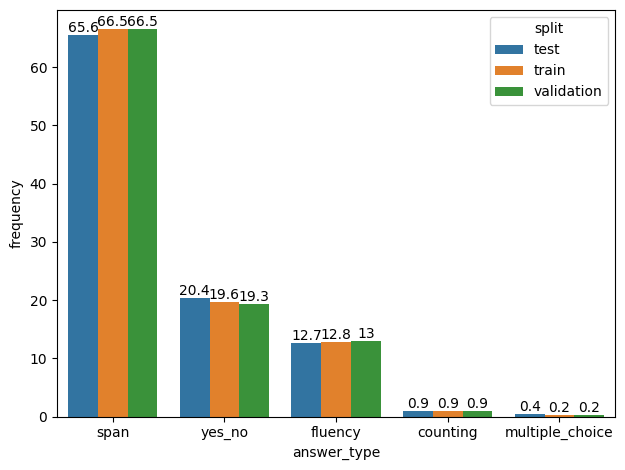

In [56]:
qa_dataset = create_dataframe(dataset)
plot_answer_type_distribution(qa_dataset)

In [57]:
del qa_dataset
del splitted_dataset
del dataset

# [Task 3] Model definition

In [25]:
@dataclass
class RationaleSelectionModelOutput(transformers.utils.ModelOutput):
    """
    Base class for outputs of question answering with rationale models.
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Total rationale extraction loss is the sum of a Binary Cross-Entropy for the tokens in the passage.
        last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`):
            Sequence of hidden-states at the output of the last layer of the model.
        hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the model at the output of each layer plus the optional initial embedding outputs.
        attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention
            heads.
        rationale_logits (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
            Rationale classification scores (before Sigmoid).
    """

    loss: Optional[torch.FloatTensor] = None
    last_hidden_state: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None
    rationale_logits: torch.FloatTensor = None


@dataclass
class QAEncoderDecoderModelOutput(transformers.utils.ModelOutput):
    """
    Class for [`QAEncoderDecoderModel`] outputs.
    Args:
        loss (`torch.FloatTensor` of shape `(1,)`, *optional*, returned when `labels` is provided):
            Language modeling loss.
        logits (`torch.FloatTensor` of shape `(batch_size, sequence_length, config.vocab_size)`):
            Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
        past_key_values (`tuple(tuple(torch.FloatTensor))`, *optional*, returned when `use_cache=True` is passed or when `config.use_cache=True`):
            Tuple of `tuple(torch.FloatTensor)` of length `config.n_layers`, with each tuple having 2 tensors of shape
            `(batch_size, num_heads, sequence_length, embed_size_per_head)`) and 2 additional tensors of shape
            `(batch_size, num_heads, encoder_sequence_length, embed_size_per_head)`.
            Contains pre-computed hidden-states (key and values in the self-attention blocks and in the cross-attention
            blocks) that can be used (see `past_key_values` input) to speed up sequential decoding.
        decoder_hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the decoder at the output of each layer plus the initial embedding outputs.
        decoder_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the decoder, after the attention softmax, used to compute the weighted average in the
            self-attention heads.
        cross_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the decoder's cross-attention layer, after the attention softmax, used to compute the
            weighted average in the cross-attention heads.
        encoder_last_hidden_state (`torch.FloatTensor` of shape `(batch_size, sequence_length, hidden_size)`, *optional*):
            Sequence of hidden-states at the output of the last layer of the encoder of the model.
        encoder_hidden_states (`tuple(torch.FloatTensor)`, *optional*, returned when `output_hidden_states=True` is passed or when `config.output_hidden_states=True`):
            Tuple of `torch.FloatTensor` (one for the output of the embeddings, if the model has an embedding layer, +
            one for the output of each layer) of shape `(batch_size, sequence_length, hidden_size)`.
            Hidden-states of the encoder at the output of each layer plus the initial embedding outputs.
        encoder_attentions (`tuple(torch.FloatTensor)`, *optional*, returned when `output_attentions=True` is passed or when `config.output_attentions=True`):
            Tuple of `torch.FloatTensor` (one for each layer) of shape `(batch_size, num_heads, sequence_length,
            sequence_length)`.
            Attentions weights of the encoder, after the attention softmax, used to compute the weighted average in the
            self-attention heads.
        encoder_rationale_logits (`torch.FloatTensor` of shape `(batch_size, sequence_length)`):
            Encoder rationale classification scores (before Sigmoid).
    """

    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    past_key_values: Optional[Tuple[Tuple[torch.FloatTensor]]] = None
    decoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    decoder_attentions: Optional[Tuple[torch.FloatTensor]] = None
    cross_attentions: Optional[Tuple[torch.FloatTensor]] = None
    encoder_last_hidden_state: Optional[torch.FloatTensor] = None
    encoder_hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    encoder_attentions: Optional[Tuple[torch.FloatTensor]] = None
    encoder_rationale_logits: Optional[torch.FloatTensor] = None


class QAEncoderDecoderModel(transformers.EncoderDecoderModel):
    def __init__(
        self,
        encoder: transformers.PreTrainedModel,
        decoder: transformers.PreTrainedModel,
        config: Optional[transformers.EncoderDecoderConfig] = None,
    ):
        super(QAEncoderDecoderModel, self).__init__(
            encoder=encoder, decoder=decoder, config=config
        )

    def tie_weights(self):
        # tie encoder & decoder if needed
        if self.config.tie_encoder_decoder:
            # tie encoder and decoder base model
            encoder_base_model_prefix = self.encoder.base_model_prefix
            decoder_base_model_prefix = self.decoder.base_model_prefix
            self._tie_encoder_decoder_weights(
                self.encoder._modules[encoder_base_model_prefix],
                self.decoder._modules[decoder_base_model_prefix],
                self.decoder.base_model_prefix,
            )

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        passage_mask: Optional[torch.BoolTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
        past_key_values: Tuple[Tuple[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        # labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        teacher_force: Optional[float] = None,
        rationale_labels: Optional[torch.BoolTensor] = None,
        **kwargs,
    ) -> Union[Tuple, transformers.modeling_outputs.Seq2SeqLMOutput]:
        kwargs_encoder = {
            argument: value
            for argument, value in kwargs.items()
            if not argument.startswith("decoder")
        }

        if encoder_outputs is None:
            encoder_outputs = self.encoder(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
                passage_mask=passage_mask,
                return_dict=return_dict,
                teacher_force=teacher_force,
                rationale_labels=rationale_labels,
                **kwargs_encoder,
            )

        outputs = super().forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            encoder_outputs=encoder_outputs,
            past_key_values=past_key_values,
            inputs_embeds=inputs_embeds,
            decoder_inputs_embeds=decoder_inputs_embeds,
            # labels=labels,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            token_type_ids=token_type_ids,
            **kwargs,
        )

        if not return_dict:
            return (outputs,) + (encoder_outputs[-1],)

        return QAEncoderDecoderModelOutput(
            **outputs, encoder_rationale_logits=encoder_outputs.rationale_logits
        )


class EncoderWithRationaleSelection(transformers.PreTrainedModel):
    base_model_prefix = "encoder"

    def __init__(self, encoder, config) -> None:
        super().__init__(config)
        self.config = config

        self.encoder = encoder
        self.rationale_head = TokenSelectionHead(config)

        self.post_init()

    def _init_weights(self, module):
        """Initialize the weights"""
        if isinstance(module, nn.Linear):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        passage_mask: Optional[torch.Tensor] = None,
        # labels: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        teacher_force: Optional[float] = None,
        rationale_labels: Optional[torch.BoolTensor] = None,
        **kwargs,
    ) -> Union[Tuple, RationaleSelectionModelOutput]:
        assert passage_mask is not None, "Passage mask is required"

        outputs = self.encoder(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask,
            inputs_embeds=inputs_embeds,
            # labels=labels,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
            **kwargs,
        )

        last_hidden_state = outputs[0]
        rationale_logits = self.rationale_head(last_hidden_state)

        passage_mask = passage_mask.unsqueeze(-1)
        p_rationale = torch.sigmoid(rationale_logits)
        # substitute the last_hidden_state[passage] with p_rationale * last_hidden_state[passage]
        # ideally, our network keeps only the span of the passage which represents the rationale
        if self.training:
            if teacher_force is not None and torch.rand(1) < teacher_force:
                p_rationale = rationale_labels.unsqueeze(-1)
        else:
            p_rationale = p_rationale > self.config.p_rationale_threshold
        last_hidden_state = last_hidden_state * (
            (1 - passage_mask) + passage_mask * p_rationale
        )

        rationale_logits = rationale_logits.squeeze(-1)

        loss = None
        if not return_dict:
            output = (last_hidden_state,) + outputs[2:] + (rationale_logits,)
            return ((loss,) + output) if loss is not None else output

        return RationaleSelectionModelOutput(
            loss=loss,
            last_hidden_state=last_hidden_state,
            rationale_logits=rationale_logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


class TokenSelectionHead(nn.Module):
    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size, bias=True)
        if isinstance(config.hidden_act, str):
            self.act_fn = transformers.modeling_utils.get_activation(config.hidden_act)
        else:
            self.act_fn = config.hidden_act
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=True)

    def forward(self, hidden_states: torch.FloatTensor) -> torch.FloatTensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.act_fn(hidden_states)
        logits = self.hidden_to_logit(hidden_states)
        return logits


def initialize_cross_attention_layer_with_self_attention_layer(
    self_attention: nn.Module,
    cross_attention: nn.Module,
    cross_attention_layer_prefix: str,
):
    uninitialized_cross_attention_weights: List[str] = []
    if cross_attention.__class__ != self_attention.__class__:
        print(
            f"{cross_attention.__class__} and {self_attention.__class__} are not equal. In this case make sure that all encoder"
            " weights are correctly initialized."
        )

    def initialize_cross_attention_with_self_attention_recursively(
        self_attention_pointer: nn.Module,
        cross_attention_pointer: nn.Module,
        module_name: str,
        uninitialized_cross_attention_weights: List[str],
        depth=0,
    ):
        assert isinstance(self_attention_pointer, nn.Module) and isinstance(
            cross_attention_pointer, nn.Module
        ), f"{self_attention_pointer} and {cross_attention_pointer} have to be of type nn.Module"
        if hasattr(self_attention_pointer, "weight"):
            assert hasattr(cross_attention_pointer, "weight")
            cross_attention_pointer.weight.data = (
                self_attention_pointer.weight.data.clone().detach()
            )
            if hasattr(self_attention_pointer, "bias"):
                assert hasattr(cross_attention_pointer, "bias")
                cross_attention_pointer.bias.data = (
                    self_attention_pointer.bias.data.clone().detach()
                )
            return

        cross_attention_modules = cross_attention_pointer._modules
        self_attention_modules = self_attention_pointer._modules
        if len(self_attention_modules) > 0:
            assert (
                len(cross_attention_modules) > 0
            ), f"Cross-attention module {cross_attention_pointer} does not match self-attention module {self_attention_pointer}"

            all_cross_attention_weights = {
                module_name + "/" + sub_name
                for sub_name in cross_attention_modules.keys()
            }
            cross_attention_layer_pos = 0
            for name, module in self_attention_modules.items():
                if name.isdigit():
                    cross_attention_name = str(int(name) + cross_attention_layer_pos)
                    self_attention_name = name
                    if not isinstance(
                        self_attention_modules[self_attention_name],
                        type(cross_attention_modules[cross_attention_name]),
                    ) and len(cross_attention_modules) != len(self_attention_modules):
                        # this can happen if the name corresponds to the position in a list module list of layers
                        # in this case the decoder has added a cross-attention that the encoder does not have
                        # thus skip this step and subtract one layer pos from encoder
                        cross_attention_layer_pos -= 1
                        continue
                elif name not in cross_attention_modules:
                    continue
                elif depth > 500:
                    raise ValueError(
                        "Max depth of recursive function `initialize_cross_attention_with_self_attention` reached. It seems that there is"
                        " a circular dependency between two or more `nn.Modules` of your model."
                    )
                else:
                    self_attention_name = cross_attention_name = name
                initialize_cross_attention_with_self_attention_recursively(
                    self_attention_modules[self_attention_name],
                    cross_attention_modules[cross_attention_name],
                    module_name + "/" + name,
                    uninitialized_cross_attention_weights,
                    depth=depth + 1,
                )
                all_cross_attention_weights.remove(
                    module_name + "/" + cross_attention_name
                )

            uninitialized_cross_attention_weights += list(all_cross_attention_weights)

    # initialize weights recursively
    initialize_cross_attention_with_self_attention_recursively(
        self_attention,
        cross_attention,
        cross_attention_layer_prefix,
        uninitialized_cross_attention_weights,
    )
    if len(uninitialized_cross_attention_weights) > 0:
        warnings.warn(
            f"The following cross_attention weights were not initialized with self_attention weights: {uninitialized_cross_attention_weights}"
        )


def initialize_cross_attention_with_self_attention(model: EncoderDecoderModel):
    decoder_base_model_prefix = model.decoder.base_model_prefix
    for layer_idx in range(model.config.decoder.num_hidden_layers):
        decoder_layer = model.decoder._modules[decoder_base_model_prefix].encoder.layer[
            layer_idx
        ]
        cross_attention = decoder_layer.crossattention
        self_attention = decoder_layer.attention
        cross_attention_name = f"layer.{layer_idx}.crossattention"
        initialize_cross_attention_layer_with_self_attention_layer(
            self_attention, cross_attention, cross_attention_name
        )
    print("Cross-attention has been initialized with self-attention weights.")


def make_encoder_decoder_model(
    checkpoint,
    tokenizer: Optional[transformers.PreTrainedTokenizer] = None,
    initialize_cross_attention=True,
):
    tokenizer, encoder = make_encoder_with_rationale_head(
        checkpoint, tokenizer=tokenizer
    )
    decoder = transformers.AutoModelForCausalLM.from_pretrained(
        checkpoint,
        is_decoder=True,
        add_cross_attention=True,
        decoder_start_token_id=tokenizer.bos_token_id,
    )

    config = transformers.EncoderDecoderConfig.from_encoder_decoder_configs(
        encoder.config,
        decoder.config,
        tie_encoder_decoder=True,
        decoder_start_token_id=tokenizer.cls_token_id,
        eos_token_id=tokenizer.sep_token_id,
        pad_token_id=tokenizer.pad_token_id,
        # sensible parameters for generation
        vocab_size=decoder.config.vocab_size,
        max_new_tokens=CONFIG.decoder_max_length,
        **CONFIG.generation,
    )

    model = QAEncoderDecoderModel(encoder=encoder, decoder=decoder, config=config)
    if initialize_cross_attention:
        initialize_cross_attention_with_self_attention(model)

    return tokenizer, model


def make_encoder_with_rationale_head(
    checkpoint, tokenizer: Optional[transformers.PreTrainedTokenizer] = None
):
    if tokenizer is None:
        tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoder = AutoModel.from_pretrained(checkpoint)
    encoder.config.p_rationale_threshold = 0.5
    encoder = EncoderWithRationaleSelection(encoder, encoder.config)
    return tokenizer, encoder

Check if everyting works fine by calling the model with a very small subsample of the dataset.

In [132]:
dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
train_data = dataset["train"].select(range(4))

In [137]:
def check_model_inputs_outputs(checkpoint_name, checkpoint, train_data: datasets.Dataset, create_model, labels_name = "labels", device="cpu"):
    print("Checkpoint:", checkpoint_name)
    tokenizer, model = create_model(checkpoint)
    model.to(device)
    preprocessing = CoQADatasetPreprocessing(tokenizer)
    tokenized_data = train_data.map(
        preprocessing.process_data_to_model_inputs,
        fn_kwargs=dict(padding="max_length"),
        batched=True,
        remove_columns=train_data.column_names,
    )
    tokenized_data.set_format("torch")
    tokenized_data = tokenized_data[:]

    forward_signature = set(inspect.signature(model.forward).parameters)
    forward_kwargs = {
        argument: value.to(device)
        for argument, value in tokenized_data.items()
        if argument in forward_signature
    }
    if "labels" in forward_kwargs:
        forward_kwargs["labels"] = tokenized_data[labels_name].to(device)
    else:
        print(f"{labels_name} ({tokenized_data[labels_name].shape}): {tokenized_data[labels_name]}")
    print("Inputs:")
    for k, v in forward_kwargs.items():
        print(f"{k} ({v.shape}): {v}")

    model_results = model(**forward_kwargs, return_dict=True)
    print("Outputs:")
    for k, v in model_results.items():
        print(f"{k}: {v}")


# EncoderWithRationaleSelection
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    check_model_inputs_outputs(checkpoint_name, checkpoint, train_data, make_encoder_with_rationale_head, labels_name="rationale_labels")

Checkpoint: distil_roberta


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

rationale_labels (torch.Size([4, 512])): tensor([[-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.]])
Inputs:
input_ids (torch.Size([4, 512])): tensor([[    0,  1779,   222,  ...,     1,     1,     1],
        [    0, 13841,   116,  ...,     1,     1,     1],
        [    0, 12375,  2164,  ...,     1,     1,     1],
        [    0,  2264,    21,  ...,     1,     1,     1]])
attention_mask (torch.Size([4, 512])): tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
passage_mask (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
rationale_labels (torch.Size([4, 512])): tensor([[-100., -100., -100.,  ..., -100., -100., -100.],
  

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

rationale_labels (torch.Size([4, 512])): tensor([[-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.],
        [-100., -100., -100.,  ..., -100., -100., -100.]])
Inputs:
input_ids (torch.Size([4, 512])): tensor([[ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 1029,  ...,    0,    0,    0],
        [ 101, 2040, 3079,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]])
token_type_ids (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
attention_mask (torch.Size([4, 512])): tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
passage_mask (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0, 

In [52]:
# EncoderDecoderModel
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    check_model_inputs_outputs(checkpoint_name, checkpoint, train_data, make_encoder_decoder_model)

Checkpoint: distil_roberta


Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.0.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer.0.crossa

Cross-attention has been initialized with self-attention weights.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

labels (torch.Size([4, 349])): tensor([[39006,   195,     2,  ...,  -100,  -100,  -100],
        [ 3750,     5,  5919,  ...,  -100,  -100,  -100],
        [12724,  1041,     2,  ...,  -100,  -100,  -100],
        [ 4308,    29,     2,  ...,  -100,  -100,  -100]])
Inputs:
input_ids (torch.Size([4, 512])): tensor([[    0,  1779,   222,  ...,     1,     1,     1],
        [    0, 13841,   116,  ...,     1,     1,     1],
        [    0, 12375,  2164,  ...,     1,     1,     1],
        [    0,  2264,    21,  ...,     1,     1,     1]])
attention_mask (torch.Size([4, 512])): tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
passage_mask (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
rationale_labels (torch.Size([4, 512])): tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0.,

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.


Map:   0%|          | 0/4 [00:00<?, ? examples/s]

labels (torch.Size([4, 349])): tensor([[2287, 1019,  102,  ..., -100, -100, -100],
        [2012, 1996, 5093,  ..., -100, -100, -100],
        [2010, 3008,  102,  ..., -100, -100, -100],
        [3456,  102, -100,  ..., -100, -100, -100]])
Inputs:
input_ids (torch.Size([4, 512])): tensor([[ 101, 2043, 2106,  ...,    0,    0,    0],
        [ 101, 2073, 1029,  ...,    0,    0,    0],
        [ 101, 2040, 3079,  ...,    0,    0,    0],
        [ 101, 2054, 2001,  ...,    0,    0,    0]])
token_type_ids (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
attention_mask (torch.Size([4, 512])): tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
passage_mask (torch.Size([4, 512])): tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0, 

# [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$, we want $f_\theta(P, Q_i) \approx A_i$.

- Our question-answering model requires two inputs: the passage $P$ and the question $Q_i$.
- The model generates the answer $A_i$.


To facilitate easy access to these inputs and outputs, we need to prepare our inputs properly. As discussed in [Task 1], given a passage $P$ and a question $Q$, the corresponding input will be obtained by concatenating $P$ to $Q$ separated by a model-dependant separator.
- DistilRoBERTa input: `<s>Question</s></s>Passage</s><pad>...<pad>`
- BERTTiny input: `[CLS] Question [SEP] Passage [SEP] [PAD] ... [PAD]`

In [4]:
class QuestionAnswerer():

    def __init__(self,
                 tokenizer: transformers.PreTrainedTokenizer,
                 model: QAEncoderDecoderModel,
                 preprocessing_config: dict = {},
                 device=None) -> None:
        self.preprocessing_config = preprocessing_config
        self.tokenizer = tokenizer
        self.device = device if device is not None\
                            else torch.device("cuda") if torch.cuda.is_available()\
                            else torch.device("cpu")
        self.model = model.to(self.device)
        self.preprocessing = CoQADatasetPreprocessing(self.tokenizer,
                                                      **preprocessing_config)

    def generate_answer(
            self,
            passage: Union[str, List[str]],
            question: Union[str, List[str]],
            history: Optional[Union[str, List[str]]] = None) -> List[str]:
        use_history = history is not None
        preprocess = batched_function(self.preprocessing.preprocess_texts)
        if isinstance(passage, str):
            passage = [passage]
            question = [question]
            history = [history]

        inputs = {
            "id": list(range(len(passage))),
            "passage": passage,
            "question": question,
        }
        if use_history:
            inputs["history"] = history

        inputs = preprocess(inputs)
        inputs = self.preprocessing.process_data_to_model_inputs(
            inputs, add_history=use_history, padding="max_length")
        inputs = inputs.convert_to_tensors("pt")

        return self.generate_answer_from_input_tensors(inputs)

    def generate_answer_from_input_tensors(self, inputs):
        if self.preprocessing_config["use_window"]:
            raise NotImplementedError()

        forward_signature = set(
            inspect.signature(self.model.forward).parameters)
        forward_signature.remove("decoder_input_ids")
        inputs = {
            argument: value.to(self.device)
            for argument, value in inputs.items()
            if argument in forward_signature
        }

        outputs = self.model.generate(**inputs)
        output_str = self.tokenizer.batch_decode(outputs,
                                                 skip_special_tokens=True)
        return output_str


The `generate_answer` method takes as input the passage(s) and the question(s) and generate the corresponding answer(s). Of course, since our models are not trained, the output is meaningless.

In [45]:
dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
train_data = dataset["train"].select(range(4))
tokenizer, model = make_encoder_decoder_model(CONFIG.checkpoints.bert_tiny)

question_answerer = QuestionAnswerer(
    tokenizer=tokenizer,
    model=model,
    preprocessing_config=CONFIG.preprocessing.__dict__)
question_answerer.generate_answer(train_data["passage"],
                                  train_data["question"])

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.


[')ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit',
 '##rasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasrasras',
 '##ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit',
 '##ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit']

# [Task 5] Question generation with text passage $P$, question $Q$ and dialogue history $H$

We want to define $f_\theta(P, Q, H)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$ and the corresponding dialogue history $H_i = \{ Q_0, A_0, \dots, Q_{i-1}, A_{i-1} \}$, we want $f_\theta(P, Q_i, H_i) \approx A_i$.

- Our question-answering model requires three inputs: the passage $P$, the question $Q_i$ and, the history $H_i$.
- The model generates the answer $A_i$.

To facilitate easy access to these inputs and outputs, we need to prepare our inputs properly. As discussed in [Task 1], truncating the history from the end seems reasonable. Hence given a passage $P$, a question $Q$ and an history $H=\{ Q_{i-k}, A_{i-k}, \dots, Q_{i-1}, A_{i-1} \}$ at turn $i$, the corresponding input will be obtained as the concatenation of $H$, $Q$ and $P$ separated by a model-dependant separator, as follows:
- DistilRoBERTa input: `<s>Qi-k</s>Ai-k</s>...Qi-1</s>Ai-1</s>Qi</s></s></s>P</s><pad>...<pad>`
- BERTTiny input: `[CLS] Qi-k [SEP] Ai-k [SEP] ... Qi-1 [SEP] Ai-1 [SEP] Qi [SEP] P [SEP] [PAD] ... [PAD]`

We choose $k=4$.

To generate the answer as explained above, we exploit the method `generate_answer` of the class `QuestionAnswerer` defined in the task before. Indeed, it takes an additional parameter `history`.

In [46]:
dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
train_data = dataset["train"].select(range(4))
tokenizer, model = make_encoder_decoder_model(CONFIG.checkpoints.bert_tiny)

question_answerer = QuestionAnswerer(
    tokenizer=tokenizer,
    model=model,
    preprocessing_config=CONFIG.preprocessing.__dict__)

question_answerer.generate_answer(train_data["passage"],
                                  train_data["question"],
                                  train_data["history"])

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Cross-attention has been initialized with self-attention weights.


[')ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit',
 ')ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit',
 '##rasritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit',
 ')ritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritritrit']

In [47]:
del dataset
del tokenizer
del model

# [Task 6] Train and evaluate $f_\theta(P, Q)$ and $f_\theta(P, Q, H)$

## TODO
- Capire come funzionano i collate. In caso, rimuovere il pad dal preprocessing e farlo fare al collate, in questo modo si risparmia sia sull'enc sia sul dec. Se non si può fare, settare la decoder_max_length a 80
- Inizializzare i pesi dell'output matrix con l'embedding matrix
- Cambiare la loss dei razionali in modo da non considerare quelli troppo lunghi
- Cambiare i pesi della loss dei razionali
- Implementare l'F1 sull'encoder

Il collate di default non permette di gestire i decoder_input_ids e la decoder_attention_mask in automatico. Capire se è necessario fare qualcosa guardando all' EncoderDecoderModel

WARNING: Forse le label non dovrebbero essere <START> answer .... <END>, ma solo answer .... <END>

In [7]:
def pipeline(hyperparameters: dict):
    with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
        config = wandb.config

        set_seed(config.seed)

        (
            model,
            train_dataloader,
            val_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            metrics,
        ) = make(config)
        print(model)

        train(
            model,
            train_dataloader,
            val_dataloader,
            loss_fn,
            optimizer,
            scheduler,
            config,
            # metrics=metrics,
        )

        evaluate(model, train_dataloader, val_dataloader, metrics, config)
        gc.collect()
        torch.cuda.empty_cache()

    return model


def make(config):
    # Make the model
    tokenizer, model = make_model(config)

    # Make the data
    train_data, val_data = get_data("train", config), get_data("validation", config)
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )

    # Make the evaluation metrics
    metrics = make_metrics(tokenizer, config)

    return (
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        metrics,
    )


def make_model(config):
    checkpoint = CONFIG.checkpoints.__dict__[config.checkpoint_name]
    if config.model_type == "encoder_decoder":
        return make_encoder_decoder_model(
            checkpoint=checkpoint,
            initialize_cross_attention=config.initialize_cross_attention,
        )
    if config.model_type == "encoder":
        return make_encoder_with_rationale_head(checkpoint=checkpoint)

    raise ValueError(
        "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
    )


def get_data(split: str, config):
    if config.get("history_length", 0) > 0:
        path = CONFIG.dataset.train_with_history(config.checkpoint_name, split=split)
    else:
        path = CONFIG.dataset.train_no_history(config.checkpoint_name, split=split)

    dataset = datasets.load_from_disk(path)
    dataset = dataset.remove_columns(
        ["id", "turn", "offset_mapping", "rationale_start", "rationale_end"]
    )
    return dataset


def make_dataloader(dataset, tokenizer, config, split: str):
    data_collator = DynamicPaddingCollatorForSeq2Seq(tokenizer)
    dataloader = create_reproducible_dataloader(
        dataset,
        batch_size=config.val_batch_size
        if split != "train" and "val_batch_size" in config
        else config.batch_size,
        collate_fn=data_collator,
        num_workers=config.val_num_workers
        if split != "train" and "val_num_workers" in config
        else config.num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader


def make_loss(config) -> ComputeLoss:
    if config.model_type == "encoder_decoder":
        # loss = composite_loss(
        #     Criterion(
        #         "rationale_loss", encoder_decoder_rationale_loss, weight=config.rationale_loss_weight
        #     ),
        #     Criterion(
        #         "generative_loss", encoder_decoder_generative_loss, weight=config.generative_loss_weight
        #     ),
        # )
        loss = UncertaintyLoss(
            Criterion(
                "rationale_loss",
                EncoderDecoderRationaleLoss(
                    max_rationale_length=CONFIG.rationale_max_length
                ),
                weight=config.rationale_loss_weight,
            ),
            Criterion(
                "generative_loss",
                encoder_decoder_generative_loss,
                weight=config.generative_loss_weight,
            ),
        )
    elif config.model_type == "encoder":
        loss = EncoderRationaleLoss(max_rationale_length=CONFIG.rationale_max_length)
    else:
        raise ValueError(
            "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
        )
    return loss


def make_optimizer(model, loss_fn, config):
    optimizer_cls = getattr(torch.optim, config.optimizer_name)
    parameters = [{"params": model.parameters()}]
    if hasattr(loss_fn, "_parameters"):
        loss_params = {"params": loss_fn.parameters()}
        if "loss_learning_rate" in config:
            loss_params["lr"] = config.loss_learning_rate
        parameters.append(loss_params)

    return optimizer_cls(
        parameters,
        lr=config.learning_rate,
        **config.get("optimizer_args", {}),
    )


def make_scheduler(optimizer, steps_per_epoch, config):
    total_steps = steps_per_epoch * config.num_epochs
    warmup_steps = int(config.warmup_fraction * total_steps)
    if config.get("scheduler", "none") != "none":
        return transformers.get_scheduler(
            config.scheduler,
            optimizer=optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )

    return DummyScheduler(optimizer=optimizer)


def make_metrics(tokenizer, config) -> Dict[str, Metric]:
    if config.model_type not in ["encoder_decoder", "encoder"]:
        raise ValueError(
            "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
        )

    metrics = {}
    metrics["encoder"] = {
        "rationale_accuracy": EncoderRationaleAccuracy(),
        "rationale_f1": EncoderRationaleF1(),
    }
    if config.model_type == "encoder_decoder":
        metrics["encoder_decoder"] = {
            "squad_f1": GenerativeSquadF1(tokenizer),
        }

    return metrics


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: torch.utils.data.DataLoader,
    loss_fn: Union[ComputeLoss, nn.Module],
    optimizer: torch.optim.Optimizer,
    lr_scheduler,
    config,
    metrics: Dict[str, Metric] = {},
):
    watch_list = [model]

    accelerator = Accelerator(mixed_precision=config.mixed_precision)
    (
        model,
        optimizer,
        train_dataloader,
        val_dataloader,
        lr_scheduler,
    ) = accelerator.prepare(
        model, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )
    if isinstance(loss_fn, nn.Module):
        watch_list.append(loss_fn)
        loss_fn = accelerator.prepare(loss_fn)

    wandb.watch(watch_list, log="all", log_freq=config.log_interval)

    # Run training and track with wandb
    steps_per_epoch = len(train_dataloader)
    total_steps = steps_per_epoch * config.num_epochs

    checkpoint_counter = 0
    step = 0
    avg_loss = AvgValue()
    avg_inner_losses = defaultdict(AvgValue)
    model.train()

    forward_signature = set(inspect.signature(model.forward).parameters)
    progress_bar = tqdm(range(total_steps))
    for epoch in range(config.num_epochs):
        for data in train_dataloader:
            inputs = {
                argument: value
                for argument, value in data.items()
                if argument in forward_signature
            }

            loss, inner_losses = train_batch(
                inputs=inputs,
                data=data,
                step=step,
                model=model,
                loss_fn=loss_fn,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                accelerator=accelerator,
                config=config,
            )
            progress_bar.update(1)

            # Compute statistics
            n_samples = len(next(iter(data.values())))
            step += 1
            avg_loss.update(loss, n_samples)
            for loss_name, loss_value in inner_losses.items():
                avg_inner_losses[f"avg_{loss_name}"].update(loss_value, n_samples)

            wandb.log(
                {
                    "train_loss": loss,
                    **inner_losses,
                    "lr": lr_scheduler.get_last_lr()[0],
                },
                step=step,
            )

            # Evaluate the model and save checkpoints
            if (step % config.log_interval == 0) or (step == total_steps):
                # Evaluate the model
                val_loss, val_inner_losses, val_metrics = train_evaluation(
                    model,
                    val_dataloader,
                    loss_fn,
                    metrics=metrics,
                )
                model.train()

                train_log(
                    avg_loss,
                    avg_inner_losses,
                    val_loss,
                    val_inner_losses,
                    val_metrics,
                    lr=lr_scheduler.get_last_lr()[0],
                    step=step,
                )
                avg_loss = AvgValue()
                avg_inner_losses = defaultdict(AvgValue)

            if step % config.checkpoint_interval == 0:
                # Saving checkpoint
                save_model_checkpoint(
                    model,
                    optimizer,
                    lr_scheduler,
                    epoch,
                    step,
                    checkpoint_counter,
                    config,
                )
                wandb.log(
                    {
                        "checkpoint_counter": checkpoint_counter,
                    },
                    step=step,
                )
                checkpoint_counter += 1

        gc.collect()
        torch.cuda.empty_cache()

    wandb.unwatch(watch_list)


def train_batch(
    inputs,
    data,
    step,
    model,
    loss_fn,
    optimizer,
    lr_scheduler,
    config,
    accelerator=None,
    device=None,
):
    assert (
        accelerator is not None or device is not None
    ), "One between accelerator and device must be set."

    if accelerator is None:
        data = {key: value.to(device) for key, value in data.items()}

    outputs = model(**inputs, return_dict=True)
    loss, inner_losses = loss_fn(outputs, data)
    if accelerator is not None:
        accelerator.backward(loss)
    else:
        loss.backward()
    if step % config.accumulation_steps == 0:
        optimizer.step()
        optimizer.zero_grad()
    lr_scheduler.step()

    return loss.item(), inner_losses


def train_evaluation(
    model, dataloader, compute_loss: ComputeLoss = None, metrics: Dict[str, Metric] = {}
) -> Tuple[AvgValue, Dict[str, AvgValue], Dict[str, AvgValue]]:
    model.eval()
    avg_loss = AvgValue()
    avg_inner_losses = defaultdict(AvgValue)
    avg_metrics = defaultdict(AvgValue)

    forward_signature = set(inspect.signature(model.forward).parameters)
    with torch.no_grad():
        for data in dataloader:
            inputs_kwargs = {
                argument: value
                for argument, value in data.items()
                if argument in forward_signature
            }
            n_samples = len(next(iter(data.values())))

            outputs = model(**inputs_kwargs, return_dict=True)
            if compute_loss is not None:
                loss, inner_losses = compute_loss(outputs, data)

                avg_loss.update(loss.item(), n_samples)
                for loss_name, loss_value in inner_losses.items():
                    avg_inner_losses[loss_name].update(loss_value, n_samples)

            for metric_name, metric in metrics.items():
                metric_value = metric(outputs, data)
                avg_metrics[metric_name].update(metric_value, n_samples)

    return avg_loss, avg_inner_losses, avg_metrics


def train_log(
    train_loss: AvgValue,
    train_inner_losses: Dict[str, AvgValue],
    val_loss: AvgValue,
    val_inner_losses: Dict[str, AvgValue],
    val_metrics: Dict[str, AvgValue],
    lr,
    step,
):
    train_loss = train_loss.avg()
    train_inner_losses = {
        f"{loss_name}": loss_value.avg()
        for loss_name, loss_value in train_inner_losses.items()
    }

    val_loss = val_loss.avg()
    val_inner_losses = {
        f"val_{loss_name}": loss_value.avg()
        for loss_name, loss_value in val_inner_losses.items()
    }

    val_metrics = {
        f"val_{metric_name}": metric_value.avg()
        for metric_name, metric_value in val_metrics.items()
    }

    wandb.log(
        {
            "avg_train_loss": train_loss,
            **train_inner_losses,
            "val_loss": val_loss,
            **val_inner_losses,
            **val_metrics,
            "lr": lr,
        },
        step=step,
    )
    print(
        f"Iteration: {step:6}",
        f"train loss: {train_loss:.4f}",
        f"val loss: {val_loss:.4f}",
        f"lr: {lr:.6f}",
        sep="\t",
    )


def save_model_checkpoint(
    model, optimizer, lr_scheduler, epoch, step, checkpoint_counter, config
):
    checkpoint_file = os.path.join(
        CONFIG.models.checkpoints_dir(
            config.model_name, config.get("history_length", 0) > 0
        ),
        config.model_name,
        f"checkpoint_{checkpoint_counter}.pt",
    )
    create_dirs_for_file(checkpoint_file)

    save_checkpoint(
        model,
        optimizer,
        lr_scheduler,
        epoch,
        step,
        checkpoint_counter,
        checkpoint_path=checkpoint_file,
    )
    wandb.save(f"{config.model_name}_{checkpoint_counter}.pt")


def load_model_checkpoint(
    checkpoint_counter, config, model, optimizer=None, lr_scheduler=None
):
    checkpoint_file = os.path.join(
        CONFIG.models.checkpoints_dir(
            config.model_name, config.get("history_length", 0) > 0
        ),
        config.model_name,
        f"checkpoint_{checkpoint_counter}.pt",
    )
    return load_checkpoint(
        checkpoint_file, model, optimizer=optimizer, scheduler=lr_scheduler
    )


def evaluate(model, train_dataloader, val_dataloader, metrics, config):
    accelerator = Accelerator(mixed_precision=config.mixed_precision)
    model, train_dataloader, val_dataloader = accelerator.prepare(
        model, train_dataloader, val_dataloader
    )

    datasets = [("train", train_dataloader), ("val", val_dataloader)]
    for dataset_name, dataloader in datasets:
        if config.model_type == "encoder_decoder":
            encoder_results = evaluate_model(
                model.encoder,
                dataloader,
                metrics["encoder"],
                config,
                get_encoder_outputs,
            )
            encoder_decoder_results = evaluate_model(
                model,
                dataloader,
                metrics["encoder_decoder"],
                config,
                get_encoder_decoder_outputs,
            )
            results = {**encoder_results, **encoder_decoder_results}
        elif config.model_type == "encoder":
            results = evaluate_model(
                model, dataloader, metrics["encoder"], config, get_encoder_outputs
            )
        else:
            raise ValueError(
                "Invalid model_type. Supported values are 'encoder_decoder' and 'encoder'."
            )

        results = {
            metric_name: metric_value.avg()
            for metric_name, metric_value in results.items()
        }

        for metric_name, metric_value in results.items():
            print(f"{dataset_name}_{metric_name}: {metric_value:.4f}")
            wandb.log({f"evaluation/{dataset_name}_{metric_name}": metric_value})


def evaluate_model(model, dataloader, metrics, config, get_outputs):
    model.eval()

    avg_metrics = defaultdict(AvgValue)
    forward_signature = set(inspect.signature(model.forward).parameters)
    with torch.no_grad():
        for data in tqdm(dataloader):
            inputs_kwargs = {
                arg: value for arg, value in data.items() if arg in forward_signature
            }
            n_samples = len(next(iter(data.values())))
            outputs = get_outputs(model, inputs_kwargs)

            for metric_name, metric in metrics.items():
                metric_value = metric(outputs, data)
                avg_metrics[metric_name].update(metric_value, n_samples)
    return avg_metrics


def get_encoder_outputs(model, inputs_kwargs):
    return model(**inputs_kwargs, return_dict=True)


def get_encoder_decoder_outputs(model, inputs_kwargs):
    inputs_kwargs.pop("decoder_input_ids", None)
    return {"output_ids": model.generate(**inputs_kwargs)}

In [5]:
# class Trainer:

#     def __init__(self, metrics, labels_name="labels") -> None:
#         self.metrics = metrics
#         self.labels_name = labels_name

#     def train_and_evaluate(self,
#                            dataset: datasets.DatasetDict,
#                            seeds=[42],
#                            **train_kwargs):
#         train_data = dataset["train"]
#         val_data = dataset["validation"]
#         test_data = dataset["test"]

#         model_results = {}
#         for seed in seeds:
#             print(f'Running with seed: {seed}...')
#             set_seed(seed)

#             model = self.train_model(train_data=train_data,
#                                      val_data=val_data,
#                                      **train_kwargs)
#             evaluate_kwargs = self._get_evaluate_kwargs(model)
#             seed_results = self.evaluate_model(model,
#                                                val_data=val_data,
#                                                test_data=test_data,
#                                                **evaluate_kwargs)

#             model_results[seed] = {"model": model, "scores": seed_results}
#             for split, metric_info in seed_results.items():
#                 for metric_name, value in metric_info.items():
#                     model_results[split][metric_name].append(value)

#         return model_results

#     def train_model(self, train_data: datasets.Dataset, val_data: datasets.Dataset, **kwargs):
#         model = self._create_model()
#         model = train_model(model=model,
#                             train_data=train_data,
#                             val_data=val_data,
#                             **kwargs)
#         return model

#     def _create_model(self):
#         raise NotImplementedError()

#     def evaluate_model(self, model, val_data, test_data=None, **kwargs):
#         datasets = {"val": val_data}
#         if test_data is not None:
#             datasets = {"test": test_data}

#         results = {}
#         for name, dataset in datasets.items():
#             predictions = self._predict(model, dataset, **kwargs)
#             metric_info = evaluate_predictions(
#                 references=dataset[self.labels_name],
#                 predictions=predictions,
#                 metrics=self.metrics)
#             results[name] = metric_info
#         return results

#     def _predict(self, model, dataset, **kwargs):
#         raise NotImplementedError()

#     def _get_evaluate_kwargs(self, model):
#         return {}


# class QAEncoderDecoderTrainer(Trainer):

#     def __init__(self,
#                  tokenizer: transformers.PreTrainedTokenizer,
#                  model_checkpoint: str,
#                  use_history=False) -> None:
#         super().__init__(metrics={"squad_f1": squad_f1}, labels_name="answer")
#         self.tokenizer = tokenizer
#         self.model_checkpoint = model_checkpoint

#     def _create_model(self):
#         _, model = make_encoder_decoder_model(self.model_checkpoint,
#                                               tokenizer=self.tokenizer)
#         return model

#     def _get_evaluate_kwargs(self, model):
#         kwargs = super()._get_evaluate_kwargs(model)
#         question_answerer = QuestionAnswerer(
#             tokenizer=self.tokenizer,
#             model=model,
#             preprocessing_config=CONFIG.preprocessing.__dict__)
#         kwargs["question_answerer"] = question_answerer
#         return kwargs

#     def _predict(self, model, data, question_answerer: QuestionAnswerer,
#                  **kwargs):
#         data = data.map(
#             lambda x:
#             {"pred": question_answerer.generate_answer_from_input_tensors(x)},
#             batched=True)
#         return data["pred"]


## Train and evaluate $f_\theta(P, Q)$

First of all, we have to process data to get inputs for the two models. Here, we have to understand how to handle questions whose number of tokens does not fit in the two models (i.e. number of tokens > 512), in the training phase.
We have two options:
- truncate the passage and discard the question if the rationale is not contained in the input. If the rationale is not in the passage, the question is likely to be unanswerable.
- take multiple windows of the same passage and sample the ones which contain the rationale.

The first approach is far easier and seems to be reasonable given that we have to discard very few questions.

In [51]:
raise

RuntimeError: No active exception to reraise

In [147]:
for checkpoint_name, checkpoint in CONFIG.checkpoints.__dict__.items():
    print("Processing data for:", checkpoint_name)
    dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    preprocessing = CoQADatasetPreprocessing(tokenizer, **CONFIG.preprocessing.__dict__)
    dataset = dataset.map(
        preprocessing.process_data_to_model_inputs,
        fn_kwargs={"add_history": False},
        batched=True,
        remove_columns=dataset["train"].column_names,
        num_proc=None,
    )
    num_rows = dataset["train"].num_rows
    print("Number of rows in the training set before removing potentially unanswerable questions:", num_rows)
    dataset["train"] = dataset["train"].filter(lambda example: np.asarray(example["rationale_start"]) != -1, batched=True)
    print("Number of rows in the training set after removing potentially unanswerable questions:", dataset["train"].num_rows)
    removed_rows = num_rows - dataset["train"].num_rows
    removed_ratio = removed_rows / num_rows
    print(f"Removed rows: {removed_rows} ({removed_ratio:.2%})")
    dataset.save_to_disk(CONFIG.dataset.train_no_history(checkpoint_name))

Processing data for: distil_roberta


Map:   0%|          | 0/85827 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/7918 [00:00<?, ? examples/s]

Number of rows in the training set before removing potentially unanswerable questions: 85827


Filter:   0%|          | 0/85827 [00:00<?, ? examples/s]

Number of rows in the training set after removing potentially unanswerable questions: 85579
Removed rows: 248 (0.29%)


Saving the dataset (0/2 shards):   0%|          | 0/85579 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7918 [00:00<?, ? examples/s]

Processing data for: bert_tiny


Map:   0%|          | 0/85827 [00:00<?, ? examples/s]

Map:   0%|          | 0/21441 [00:00<?, ? examples/s]

Map:   0%|          | 0/7918 [00:00<?, ? examples/s]

Number of rows in the training set before removing potentially unanswerable questions: 85827


Filter:   0%|          | 0/85827 [00:00<?, ? examples/s]

Number of rows in the training set after removing potentially unanswerable questions: 85574
Removed rows: 253 (0.29%)


Saving the dataset (0/2 shards):   0%|          | 0/85574 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/21441 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/7918 [00:00<?, ? examples/s]

## TODO

### Problema
Capire cosa cazzo fanno i decoder_input_ids, mannaggia al cristo. Se li passo al generate, per qualche ragione della minchia spara in output gli input dati + la risposta generata. Capire se è solo un problema del generate o se accade la stessa cosa anche nel forward.

Cercare roba su internet o guardare l'implementazione. Magari printando qualcosa o vedendo che cazzo fa BART. Capire il problema dello shift a destra delle label.


### Altri problemi meno importanti
Capire come bilanciare la loss del razionale
https://digitalcommons.usf.edu/cgi/viewcontent.cgi?article=1032&context=mth_facpub

In [26]:
class PropertyDict(dict):
    def __getattr__(self, key):
        if key in self:
            return self[key]
        raise AttributeError(
            f"'{self.__class__.__name__}' object has no attribute '{key}'"
        )

    def __setattr__(self, key, value):
        self[key] = value


hyperparameters = PropertyDict(
    seed=42,
    checkpoint_name="bert_tiny",
    model_name="bert_tiny_enc",
    model_type="encoder",
    initialize_cross_attention=True,
    generative_loss_weight=0.6,
    rationale_loss_weight=15.0,
    batch_size=16,
    val_batch_size=64,
    num_workers=4,
    # num_workers=0,
    # val_num_workers=2,
    # num_epochs=8,
    num_epochs=3,
    optimizer_name="AdamW",
    learning_rate=5e-3,
    # loss_learning_rate=1e-1,
    scheduler="linear",
    warmup_fraction=0.1,
    accumulation_steps=1,
    mixed_precision="fp16",
    checkpoint_interval=1000,
    log_interval=1000,
    # checkpoint_interval=5,
    # log_interval=5,
)

with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
    config = wandb.config

    set_seed(config.seed)

    tokenizer, model = make_model(config)

    # # Make the data
    train_data = get_data("train", config)
    val_data = get_data("validation", config)
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )

    # Make the evaluation metrics
    metrics = make_metrics(tokenizer, config)

    # model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, metrics = make(config)
    print(model)

    train(
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        config,
    )

    evaluate(model, train_dataloader, val_dataloader, metrics, config)

# pipeline(hyperparameters)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EncoderWithRationaleSelection(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12

  0%|          | 0/16047 [00:00<?, ?it/s]

Iteration:   1000	train loss: 0.6394	val loss: 0.6592	lr: 0.003117


## Small dataset

In [15]:
class PropertyDict(dict):
    def __getattr__(self, key):
        if key in self:
            return self[key]
        raise AttributeError(
            f"'{self.__class__.__name__}' object has no attribute '{key}'"
        )

    def __setattr__(self, key, value):
        self[key] = value


hyperparameters = PropertyDict(
    seed=42,
    checkpoint_name="bert_tiny",
    model_name="bert_tiny_enc",
    model_type="encoder",
    initialize_cross_attention=True,
    generative_loss_weight=0.6,
    rationale_loss_weight=15.0,
    batch_size=8,
    val_batch_size=64,
    num_workers=0,
    num_epochs=10,
    optimizer_name="AdamW",
    learning_rate=5e-3,
    # loss_learning_rate=1e-1,
    scheduler="linear",
    warmup_fraction=0.1,
    accumulation_steps=1,
    mixed_precision="fp16",
    checkpoint_interval=5,
    log_interval=5,
)

with wandb.init(project=CONFIG.wandbConfig.project, config=hyperparameters):
    config = wandb.config

    set_seed(config.seed)

    tokenizer, model = make_model(config)

    # # Make the data
    train_data = get_data("train", config).shuffle(42).select(range(16))
    val_data = get_data("validation", config).shuffle(42).select(range(64))
    train_dataloader = make_dataloader(train_data, tokenizer, config, split="train")
    val_dataloader = make_dataloader(val_data, tokenizer, config, split="validation")

    # Make the loss, the optimizer and the scheduler
    loss_fn = make_loss(config)
    optimizer = make_optimizer(model, loss_fn, config)
    scheduler = make_scheduler(
        optimizer, steps_per_epoch=len(train_dataloader), config=config
    )

    # Make the evaluation metrics
    metrics = make_metrics(tokenizer, config)

    # model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, metrics = make(config)
    print(model)

    train(
        model,
        train_dataloader,
        val_dataloader,
        loss_fn,
        optimizer,
        scheduler,
        config,
    )

    evaluate(model, train_dataloader, val_dataloader, metrics, config)

# pipeline(hyperparameters)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EncoderWithRationaleSelection(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12

  0%|          | 0/20 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Iteration:      5	train loss: 1.4317	val loss: 0.6935	lr: 0.004167
Iteration:     10	train loss: 0.7578	val loss: 0.6970	lr: 0.002778
Iteration:     15	train loss: 0.7037	val loss: 0.6976	lr: 0.001389
Iteration:     20	train loss: 0.6946	val loss: 0.6935	lr: 0.000000


  0%|          | 0/2 [00:00<?, ?it/s]

train_rationale_accuracy: 0.9670
train_rationale_f1: 0.4916


  0%|          | 0/1 [00:00<?, ?it/s]

val_rationale_accuracy: 0.9724
val_rationale_f1: 0.4929


In [225]:
# l = EncoderRationaleLoss(100)
# print(isinstance(l, nn.Module))
# l = l.to("cuda")
# next(l.parameters()).device

True


device(type='cuda', index=0)

In [163]:
len(train_dataloader)

2

In [122]:
# accelerator = Accelerator(mixed_precision=hyperparameters.mixed_precision)
# model, train_dataloader, val_dataloader = accelerator.prepare(
#     model, train_dataloader, val_dataloader
# )
# model.eval()

# forward_signature = set(inspect.signature(model.forward).parameters)
# with torch.no_grad():
#     data = next(train_dataloader.__iter__())
#     inputs_kwargs = {
#         arg: value for arg, value in data.items() if arg in forward_signature
#     }
#     # inputs_kwargs.pop("decoder_input_ids")
#     outputs = get_encoder_outputs(model, inputs_kwargs)

#     loss_fn = make_loss(hyperparameters)
#     l = loss_fn(outputs, data)
# l

(tensor(0.0191, device='cuda:0'), {})

In [171]:
rationale_labels = train_data["rationale_labels"]
passage_mask = train_data["passage_mask"]

print(rationale_labels)
print(passage_mask)

[[-100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, -100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

[autoreload of src.losses failed: Traceback (most recent call last):
  File "d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\IPython\extensions\autoreload.py", line 345, in update_class
    if update_generic(old_obj, new_obj):
  File "d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\IPython\extensions

In [170]:
positives = np.sum([np.count_nonzero(np.asarray(labels, dtype=np.int32) == 1) for labels in rationale_labels])
negatives = np.sum([np.count_nonzero(np.asarray(labels, dtype=np.int32) == 0) for labels in rationale_labels])
totals = np.sum([np.count_nonzero(mask) for mask in passage_mask])

print("P:", positives)
print("N:", negatives)
print("T:", totals)

assert totals == positives + negatives

P: 2787
N: 83840
T: 86627


In [113]:
# evaluate(model, val_dataloader, {'enc_dec': EncoderDecoderRationaleF1}, hyperparameters)

In [ ]:
raise

In [3]:
seed = 42
checkpoint_name = "bert_tiny"
checkpoint = CONFIG.checkpoints.__dict__[checkpoint_name]
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
data_collator = DynamicPaddingCollatorForSeq2Seq(tokenizer)

dataset = datasets.load_from_disk(CONFIG.dataset.train_no_history(checkpoint_name))
dataset = dataset.remove_columns(
    ["id", "turn", "offset_mapping", "rationale_start", "rationale_end"]
)

train_data = dataset["train"].select(range(1))
val_data = dataset["validation"].shuffle(seed).select(range(5*64))

set_seed(seed)
_, model = make_encoder_decoder_model(
    checkpoint=checkpoint,
    tokenizer=tokenizer,
    initialize_cross_attention=False,
)

loss = composite_loss(
    Criterion("rationale_loss", rationale_loss, weight=15.0),
    Criterion("generative_loss", generative_loss),
)
torch.cuda.empty_cache()
gc.collect()
train_model(
    model,
    train_data,
    val_data,
    compute_loss=loss,
    train_batch_size=8,
    val_batch_size=64,
    collate_fn=data_collator,
    train_num_workers=0,
    val_num_workers=2,
    scheduler="none",
    model_name="bert_tiny_1",
    model_dir=CONFIG.model_dir,
    wandb_init_kwargs=CONFIG.wandbConfig.__dict__,
    num_epochs = 30,
    checkpoint_interval=5,
)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

  0%|          | 0/30 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Iteration: 5 Train Loss: 25.335338592529297 Val Loss: 25.975282287597658
Iteration: 10 Train Loss: 20.95184326171875 Val Loss: 25.23537826538086
Iteration: 15 Train Loss: 17.348697662353516 Val Loss: 24.722093963623045
Iteration: 20 Train Loss: 15.533953666687012 Val Loss: 24.16294059753418
Iteration: 25 Train Loss: 16.60929298400879 Val Loss: 23.72282295227051
Iteration: 30 Train Loss: 10.984734535217285 Val Loss: 23.4992618560791


In [64]:
model

QAEncoderDecoderModel(
  (encoder): EncoderWithRationaleSelection(
    (encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-1): 2 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=128, out_fea

In [19]:
train_dataloader = create_reproducible_dataloader(
        train_data,
        shuffle=True,
        batch_size=8,
        collate_fn=data_collator,
        # num_workers=4,
    )

In [22]:
for x in train_dataloader:
    print(type(x))
    print(x.__dict__)

<class 'transformers.tokenization_utils_base.BatchEncoding'>
{'data': {'input_ids': tensor([[  101,  2043,  2106,  2358, 21332,  2707,  2652,  5093,  1029,   102,
          2000,  2131,  2000,  1996,  5093,  2457,  1010, 17639,  2358, 21332,
          2038,  2000,  5245,  2010, 13204,  2045,  1012,  1996,  2321,  1011,
          6300,  2050,  1011,  2214,  2013,  2167,  3792,  1010,  2149,  2001,
          2141,  2302,  3456,  1012,  2021,  2043,  2002, 11214,  2039,  2010,
         10958,  2278, 12647,  1998,  4269,  2000,  2718,  1037,  3608,  1010,
          2017,  2855,  2156,  2008,  1996,  2402,  2158,  2074,  2215,  2000,
          2663,  1012,  2358, 21332,  2211,  2652,  5093,  2012,  2287,  1019,
          2012,  1996,  2235,  5093,  2252,  2010,  3008,  2219,  1012,  2005,
          2086,  1010,  2002,  2209,  2114,  2583,  1011, 22549,  2867,  2011,
          5128,  8903,  2006,  1996, 22475,  2015,  1997,  2010,  3456,  1012,
          2295,  2002,  2001,  1037,  3329,  10

In [ ]:
del dataset

### Bert Tiny

In [ ]:
dataset = datasets.load_from_disk(CONFIG.dataset.train_no_history("bert_tiny"))
x = dataset.filter(
    lambda example: np.asarray(example["rationale_start"]) == -1, batched=True)
x

In [ ]:
253 / 85891 * 100

### Distil-Roberta

In [ ]:
dataset = datasets.load_from_disk(
    CONFIG.dataset.train_no_history("distil_roberta"))
dataset

In [ ]:
metrics = {"squad_f1": squad_f1}

checkpoint = CONFIG.checkpoints.bert_tiny
tokenizer, AutoTokenizer.from_pretrained(checkpoint)
QuestionAnswerer()

seeds = [42, 2022, 1337]
avg_metric_info = {}

validation_results = collections.defaultdict(list)
test_results = collections.defaultdict(list)
for seed in seeds:
    print(f'Running with seed: {seed}')
    set_seed(seed)

    tokenizer, model = make_encoder_decoder_model(checkpoint,
                                                  tokenizer=tokenizer)
    model = train_model(model=model)

    question_answerer = QuestionAnswerer(
        tokenizer=tokenizer,
        model=model,
        preprocessing_config=CONFIG.preprocessing.__dict__)
    val_predictions = val_data.map(question_answerer.generate_answer,
                                   input_columns=["passage", "question"],
                                   batched=True)
    predictions = test_data.map(
        lambda x: {"pred": question_answerer.generate_answer(*x)},
        input_columns=["passage", "question"],
        batched=True)

    metric_info = evaluate_predictions(predictions=predictions,
                                       y=y_test,
                                       metrics=metrics,
                                       metric_names=metric_names)
    for metric, value in metric_info.items():
        avg_metric_info.setdefault(metric, []).append(value)

avg_metric_info = {
    key: np.mean(value)
    for key, value in avg_metric_info.items()
}
print(f'Metrics info: \n{avg_metric_info}')

# [Task 7]

# [......]

In [ ]:
# from torchviz import make_dot
# token_type_ids = torch.Tensor([0, 0, 0, 1, 1])
# w = torch.tensor([0.1, 0.2, 0.3, 0.8, 0.1], requires_grad=True)
# hidden_states = w * torch.Tensor([5, 4, 3, 2, 1])
# p_token = hidden_states * 0.8
# p_token = p_token.masked_fill(~token_type_ids.bool(), 1)
# print(p_token)
# y = p_token * hidden_states

# # external_grad = torch.ones_like(y)
# # y.backward(gradient=external_grad)
# print(y)
# y = y.sum()
# y.backward()

# print(y)
# print(w.grad)

# make_dot(y)

In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, tokenizer, encoder_max_len=512, decoder_max_len=64):
        super(TokenizedDataset).__init__()
        self.df = df
        self.tokenizer = tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        # history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]*
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            'token_type_ids':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            'passage_mask':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            # #rationale
            # 'rat_start_idx':
            # torch.tensor(start_idx, dtype=torch.int64),
            # 'rat_end_idx':
            # torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

In [ ]:
def unpack_qna(df, history_len):
    unpacked_df = []

    for _, row in df.iterrows():
        history = ''
        qa_pairs = list(zip(row['questions'], row['answers']))
        for idx, (question, answer) in enumerate(qa_pairs):
            history = ''.join([
                qa_pairs[i][0]['text'] + ' ' + qa_pairs[i][1]['text'] + '. '
                for i in range(max(0, idx - history_len), idx)
            ])
            data = {
                'source': row['source'],
                'passage': row['passage'],
                'question': question['text'],
                'answer': answer['text'],
                'rationale': answer['rationale'],
                'span_start': answer['span_start'],
                'span_end': answer['span_end'],
                'history': history
            }
            unpacked_df.append(data)

    unpacked_df = pd.DataFrame(unpacked_df)
    unpacked_df.reset_index(drop=True, inplace=True)

    return unpacked_df


df_train, df_val = train_test_split(df[df['split'] == 'train'],
                                    train_size=0.8,
                                    random_state=42)
df_val['split'] = 'val'
df_test = df[df['split'] == 'test']

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f"Train shape: {df_train.shape}")
print(f"  Val shape: {df_val.shape}")
print(f" Test shape:  {df_test.shape}")

train_data = unpack_qna(df_train, 3).sample(1024)
val_data = unpack_qna(df_val, 3).sample(1024)
test_data = unpack_qna(df_test, 3).sample(1024)

In [ ]:
def train_model(model,
                train_dataset,
                val_dataset,
                epochs=3,
                save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Creating datasets...")

    # Prepare DataLoaders
    print("Creating dataloaders...")
    train_loader = create_reproducible_dataloader(train_dataset,
                                                  batch_size=32,
                                                  drop_last=False,
                                                  shuffle=True,
                                                  num_workers=2,
                                                  pin_memory=True)
    val_loader = create_reproducible_dataloader(val_dataset,
                                                batch_size=32,
                                                drop_last=False,
                                                shuffle=True,
                                                num_workers=2,
                                                pin_memory=True)

    optimizer = AdamW(model.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    print("Training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        # for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model(**inputs, labels=labels).loss

            epoch_loss += loss.item()
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model(**inputs, labels=labels).loss

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss


# generative_model = GenerativeModel('BERTTiny', "prajjwal1/bert-tiny", device=device)
k, model = make_encoder_decoder_model(BERT_TINY)
dataset = TokenizedDataset(train_data, k)
val_data = TokenizedDataset(val_data, k)
history = train_model(model, dataset, val_data)
# history = train_model(M2, train_test, val_test)
print("Train complete")

In [ ]:
# max_length = 384
# stride = 128

# def preprocess_training_examples(examples):
#     questions = [q.strip() for q in examples["question"]]
#     inputs = tokenizer(
#         questions,
#         examples["context"],
#         max_length=max_length,
#         truncation="only_second",
#         stride=stride,
#         return_overflowing_tokens=True,
#         return_offsets_mapping=True,
#         padding="max_length",
#     )

#     offset_mapping = inputs.pop("offset_mapping")
#     sample_map = inputs.pop("overflow_to_sample_mapping")
#     answers = examples["answers"]
#     start_positions = []
#     end_positions = []

#     for i, offset in enumerate(offset_mapping):
#         sample_idx = sample_map[i]
#         answer = answers[sample_idx]
#         start_char = answer["answer_start"][0]
#         end_char = answer["answer_start"][0] + len(answer["text"][0])
#         sequence_ids = inputs.sequence_ids(i)

#         # Find the start and end of the context
#         idx = 0
#         while sequence_ids[idx] != 1:
#             idx += 1
#         context_start = idx
#         while sequence_ids[idx] == 1:
#             idx += 1
#         context_end = idx - 1

#         # If the answer is not fully inside the context, label is (0, 0)
#         if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
#             start_positions.append(0)
#             end_positions.append(0)
#         else:
#             # Otherwise it's the start and end token positions
#             idx = context_start
#             while idx <= context_end and offset[idx][0] <= start_char:
#                 idx += 1
#             start_positions.append(idx - 1)

#             idx = context_end
#             while idx >= context_start and offset[idx][1] >= end_char:
#                 idx -= 1
#             end_positions.append(idx + 1)

#     inputs["start_positions"] = start_positions
#     inputs["end_positions"] = end_positions
#     return inputs

In [ ]:
t = AutoTokenizer.from_pretrained(DISTIL_ROBERTA)
t._tokenizer.post_processor

inputs = t(question, passage)
t.decode(inputs["input_ids"])

In [ ]:
k = AutoTokenizer.from_pretrained(BERT_TINY)
passage = dataset["train"][0]["passage"]
question = dataset["train"][0]["question"]["text"]

print("P:", passage)
print("Q:", question)

inputs = k(question, passage)
k.decode(inputs["input_ids"])

In [ ]:
input_ids = k(
    "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side.During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was  finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft).Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.",
    return_tensors="pt",
).input_ids

labels = k(
    "the eiffel tower surpassed the washington monument to become the tallest structure in the world. it was the first structure to reach a height of 300 metres in paris in 1930. it is now taller than the chrysler building by 5. 2 metres ( 17 ft ) and is the second tallest free - standing structure in paris.",
    return_tensors="pt",
).input_ids
passage_mask = torch.ones(size=(input_ids.shape[-1], ))
passage_mask[0] = 0
y = model(input_ids=input_ids, passage_mask=passage_mask, labels=labels)

In [ ]:
y.encoder_last_hidden_state

In [ ]:
hs, pool = y
print(hs.shape)
print(pool.shape)

In [ ]:
target = datasets.load_from_disk(dataset_folder)
target

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


optimizer = AdamW(model.parameters(), lr=3e-5)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

checkpoints_dir = "bert-tiny-coqa"
training_args = TrainingArguments(checkpoints_dir, evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=k,
    compute_metrics=compute_metrics,
)

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
k = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return k(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=k)

In [ ]:
def tokenize_function(example):
    return k(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
samples = tokenized_datasets["train"]
samples = {
    k: v
    for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]
}


In [ ]:
checkpoint = "bert-tiny"
k = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=k)

batch = data_collator(samples)

In [ ]:
### NEED TO FIX THE HISTORY CREATION


def unpack_qna(df, history_len):
    unpacked_df = []

    for _, row in df.iterrows():
        history = ''
        qa_pairs = list(zip(row['questions'], row['answers']))
        for idx, (question, answer) in enumerate(qa_pairs):
            history = ''.join([
                qa_pairs[i][0]['text'] + ' ' + qa_pairs[i][1]['text'] + '. '
                for i in range(max(0, idx - history_len), idx)
            ])
            data = {
                'source': row['source'],
                'passage': row['passage'],
                'question': question['text'],
                'answer': answer['text'],
                'rationale': answer['rationale'],
                'span_start': answer['span_start'],
                'span_end': answer['span_end'],
                'history': history
            }
            unpacked_df.append(data)

    unpacked_df = pd.DataFrame(unpacked_df)
    unpacked_df.reset_index(drop=True, inplace=True)

    return unpacked_df


# train_data = unpack_qna(df_train, 3)
# val_data = unpack_qna(df_val, 3)
# test_data = unpack_qna(df_test, 3)

In [ ]:
train_data = unpack_qna(df, 3)
train_data

## Stuff

As first thing, we had to chose the the maximum length doing a good trade-off within too long inputs and truncate too many and looging information. 

Choosing 512 as max length, more than 95% of the input can be represented.

In [ ]:
k = AutoTokenizer.from_pretrained(BERT_TINY)

input = train_data['question'] + k.sep_token + k.sep_token + train_data[
    'passage']
num_tokens_no_hist = input.apply(lambda text: len(k(text).input_ids))

# input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(num_tokens_no_hist, bins=200)
plt.axvline(512, c='r', label='512 tokens')
plt.axvline(np.percentile(num_tokens_no_hist, 95),
            c='g',
            label='95-th percentile')
plt.axvline(np.percentile(num_tokens_no_hist, 99),
            c='b',
            label='99-th percentile')
plt.legend()
plt.xlim(0, 800)
plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# plt.subplot(1, 2, 2)
# plt.hist(num_tokens_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa with hist')
plt.show()

## [Task 3] Model definition

In [ ]:
model_checkpoints = "prajjwal1/bert-tiny"
ed = EncoderDecoderModel.from_encoder_decoder_pretrained(
    model_checkpoints, model_checkpoints, tie_encoder_decoder=True)

print(ed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_checkpoints = "prajjwal1/bert-tiny"


class GenerativeModel(torch.nn.Module):

    def __init__(self, name, model_checkpoints, device, **kwargs):
        super(GenerativeModel, self).__init__(**kwargs)
        self.name = name
        self.device = device

        # Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

        # Encoder-Decoder model that its used as a generator for answer
        self.generator = EncoderDecoderModel.from_encoder_decoder_pretrained(
            model_checkpoints, model_checkpoints, tie_encoder_decoder=True)
        # decoder configuration
        self.generator.config.decoder.is_decoder = True
        self.generator.config.decoder.add_cross_attention = True

        # model configuration
        self.generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
        self.generator.config.eos_token_id = self.tokenizer.sep_token_id
        self.generator.config.pad_token_id = self.tokenizer.pad_token_id
        self.generator.config.vocab_size = self.generator.config.decoder.vocab_size

        # Generation parameters
        self.generator.config.max_length = 64
        self.generator.config.min_length = 2
        self.generator.config.no_repeat_ngram_size = 3
        self.generator.config.finetuning_task = True
        self.generator.config.repetition_penalty = 3.0
        self.generator.config.num_beams = 10

    def forward(self, inputs, labels, **kwargs):
        # Train on Question & Answer
        loss = self.generator(input_ids=inputs["input_ids"],
                              attention_mask=inputs["attention_mask"],
                              labels=labels).loss

        return loss

    def generate(self, inputs, **kwargs):
        # Predict Answer from Question
        pred_answer = self.generator.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"])

        return pred_answer

In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, model, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        # history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            #rationale
            'rat_start_idx':
            torch.tensor(start_idx, dtype=torch.int64),
            'rat_end_idx':
            torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

### Training

In [ ]:
def train_model(model, train_data, val_data, epochs=3, save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Creating datasets...")
    train_dataset = TokenizedDataset(train_data, model)
    val_dataset = TokenizedDataset(val_data, model)

    # Prepare DataLoaders
    print("Creating dataloaders...")
    train_loader = create_reproducible_dataloader(train_dataset,
                                                  batch_size=32,
                                                  drop_last=False,
                                                  shuffle=True,
                                                  num_workers=2,
                                                  pin_memory=True)
    val_loader = create_reproducible_dataloader(val_dataset,
                                                batch_size=32,
                                                drop_last=False,
                                                shuffle=True,
                                                num_workers=2,
                                                pin_memory=True)

    optimizer = AdamW(model.generator.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    print("Training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        # for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model.forward(inputs, labels)

            epoch_loss += float(loss)
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model.forward(inputs, labels)

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss


train_test = train_data[:128]
val_test = train_data[:128]

generative_model = GenerativeModel('BERTTiny',
                                   "prajjwal1/bert-tiny",
                                   device=device)
history = train_model(generative_model, train_data, val_data)
# history = train_model(M2, train_test, val_test)
print("Train complete")

In [ ]:
class model(torch.nn.Module):

    def __init__(self, name, model_checkpoints, **kwargs):
        super(model, self).__init__(**kwargs)
        self.name = name
        self.device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

        # Tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)

        # Encoder-Decoder model that its used as a generator for answer
        self.generator = EncoderDecoderModel.from_encoder_decoder_pretrained(
            model_checkpoints, model_checkpoints, tie_encoder_decoder=True)
        # Rationale extractor
        self.extractor = AutoModelForQuestionAnswering.from_pretrained(
            model_checkpoints)

        # decoder configuration
        self.generator.config.decoder.is_decoder = True
        self.generator.config.decoder.add_cross_attention = True

        # model configuration
        self.generator.config.decoder_start_token_id = self.tokenizer.cls_token_id
        self.generator.config.eos_token_id = self.tokenizer.sep_token_id
        self.generator.config.pad_token_id = self.tokenizer.pad_token_id
        self.generator.config.vocab_size = self.generator.config.decoder.vocab_size

        # Generation parameters
        self.generator.config.max_length = 64
        self.generator.config.min_length = 2
        self.generator.config.no_repeat_ngram_size = 3
        self.extractor.config.finetuning_task = True
        self.generator.config.finetuning_task = True
        self.generator.config.repetition_penalty = 3.0
        self.generator.config.num_beams = 10

    def forward(self, inputs, labels):
        # predict rationale with Q and P: [CLS] Q [SEP] P [SEP] [PAD]* -> rat_start_idx, rat_end_idx
        pred_rat_idxs = self.extractor(input_ids=inputs["input_ids"],
                                       attention_mask=inputs["attention_mask"],
                                       start_positions=inputs["rat_start_idx"],
                                       end_positions=inputs["rat_end_idx"])

        # get predicted start, end indexs
        pred_rat_s_idx = torch.argmax(pred_rat_idxs.start_logits, dim=-1)
        pred_rat_e_idx = torch.argmax(pred_rat_idxs.end_logits, dim=-1)

        ### EXTRAT PREDICTED RATIONALES
        ### if the start and end rationale index are completly wrong, just use Question and Passage for train
        if pred_rat_s_idx < pred_rat_e_idx and pred_rat_e_idx < inputs[
                'input_ids'].shape[-1]:
            new_inputs = inputs["input_ids"].cpu().numpy()
            max_length = inputs['input_ids'].shape[-1]

            # get the predict rationale  input = [CLS] Q [SEP] P [SEP] [PAD]* -> P[pred_rat_s_idx:pred_rat_e_idx] / P
            pred_rat = list(
                map(
                    lambda x, s_idx, e_idx: x[s_idx:e_idx]
                    if e_idx < max_length and s_idx < e_idx else x[np.where(
                        x == self.tokenizer.sep_token_id)[0][0] + 1:np.where(
                            x == self.tokenizer.sep_token_id)[0][0] + 1:],
                    inputs["input_ids"], pred_rat_s_idx, pred_rat_e_idx))

        else:
            gen_loss = self.generator(input_ids=inputs["input_ids"],
                                      attention_mask=inputs["attention_mask"],
                                      labels=labels).loss

        # get the question_ids input = [CLS] Q [SEP] P [SEP] [PAD]* -> [CLS] Q [SEP]
        #q_ids = list(map(lambda x: x[:torch.where(x == sep_token)[0][0] + 1], inputs["input_ids"]))

        ### RECONSTRUCT INPUT FOR THE 2ND NETWORK
        ### if rat found -> [CLS] Q [SEP] R [SEP] [PAD]
        ### if rat = ''  -> [CLS] Q [SEP] P [SEP] [PAD]
        new_inputs = list(
            map(
                lambda x, q, r: torch.cat(
                    (q, r, sep_token,
                     torch.tensor([pad_token] * (max_length - len(q) - len(r) -
                                                 1)).to(self.device)))
                if r is not None else x, inputs["input_ids"], q_ids, pred_rat))

        new_inputs = torch.stack(new_inputs).to(self.device)
        new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0),
                                    dtype=torch.int64).to(self.device)

        ### Predict from question and generated rationale
        gen_loss = self.generator(input_ids=new_inputs,
                                  attention_mask=new_att_mask,
                                  labels=labels).loss

        return gen_loss + pred_rat_idxs.loss

    def generate(self, inputs, **kwargs):
        sep_token = torch.tensor([self.tokenizer.sep_token_id]).to(self.device)
        pad_token = torch.tensor([self.tokenizer.pad_token_id]).to(self.device)
        max_length = torch.tensor(inputs['input_ids'].shape[-1]).to(
            self.device)

        # predict rationale with Q and P: [CLS] Q [SEP] P [SEP] [PAD]* -> rat_start_idx, rat_end_idx
        pred_rat_idxs = self.extractor(input_ids=inputs["input_ids"],
                                       attention_mask=inputs["attention_mask"])

        # get predicted start, end indexs
        pred_rat_s_idx = torch.argmax(pred_rat_idxs.start_logits, dim=-1)
        pred_rat_e_idx = torch.argmax(pred_rat_idxs.end_logits, dim=-1)

        ### EXTRAT PRED RATIONALE

        # get the question_ids input = [CLS] Q [SEP] P [SEP] [PAD]* -> [CLS] Q [SEP]
        q_ids = list(
            map(lambda x: x[:torch.where(x == sep_token)[0][0] + 1],
                inputs["input_ids"]))

        # get the predict rationale  input = [CLS] Q [SEP] P [SEP] [PAD]* -> P[pred_rat_s_idx:pred_rat_e_idx] / None
        pred_rat = list(
            map(
                lambda x, q, s_idx, e_idx: x[len(q) + s_idx:len(q) + e_idx]
                if len(q) + s_idx < max_length and s_idx < e_idx else None,
                inputs["input_ids"], q_ids, pred_rat_s_idx, pred_rat_e_idx))

        ### RECONSTRUCT INPUT FOR THE 2ND NETWORK
        ### if rat found -> [CLS] Q [SEP] R [SEP] [PAD]
        ### if rat = ''  -> [CLS] Q [SEP] P [SEP] [PAD]
        new_inputs = list(
            map(
                lambda x, q, r: torch.cat(
                    (q, r, sep_token,
                     torch.tensor([pad_token] * (max_length - len(q) - len(r) -
                                                 1)).to(self.device)))
                if r is not None else x, inputs["input_ids"], q_ids, pred_rat))

        new_inputs = torch.stack(new_inputs).to(self.device)
        new_att_mask = torch.tensor(torch.where(new_inputs != pad_token, 1, 0),
                                    dtype=torch.int64).to(self.device)

        ### Predict from question and generated rationale
        pred_answer = self.generator.generate(input_ids=new_inputs,
                                              attention_mask=new_att_mask)

        return pred_answer


Create custom dataset for train


In [ ]:
k = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

In [ ]:
row = train_data.iloc[3500]
q = row.question
p = row.passage
s_start = row.span_start
s_end = row.span_end

ids = np.array(
    tok(q, p, padding='max_length', truncation=True,
        max_length=128)["input_ids"])
#print("ids: ", ids)
print("ids_dec:", tok.decode(ids))
print("span idx: ", s_start, s_end)
print("span: ", p[s_start:s_end])
print("pred_span: ", tok.decode(ids[s_start:s_end]))

new_p = np.array(
    tok(p[:s_start] + tok.sep_token + p[s_start:s_end] + tok.sep_token +
        p[s_end + 1:]).input_ids)
i_s, i_e = np.where(new_p == tok.sep_token_id)[0][0], np.where(
    new_p == tok.sep_token_id)[0][1]
print("pred_span2: ", tok.decode(ids[i_s:i_e]))

q_len = len(ids[:np.where(ids == tok.sep_token_id)[0][0]])
print("pred_span3: ", tok.decode(ids[q_len + i_s:q_len + i_e - 1]))


In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, model, encoder_max_len=512, decoder_max_len=32):
        super(TokenizedDataset).__init__()
        self.df = df
        self.name = model.name
        self.tokenizer = model.tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        rationale_encoding = self.tokenizer(
            question,
            rationale,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            'rationale_ids':
            torch.tensor(rationale_encoding.input_ids, dtype=torch.int64),
            'rationlale_mask':
            torch.tensor(rationale_encoding.attention_mask, dtype=torch.int64),
            'rat_start_idx':
            torch.tensor(start_idx, dtype=torch.int64),
            'rat_end_idx':
            torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

## Training


In [ ]:
def train_model(model,
                train_data,
                val_data,
                validation=True,
                save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = TokenizedDataset(train_data, model)
    val_dataset = TokenizedDataset(val_data, model)

    # Prepare DataLoaders
    train_loader = create_reproducible_dataloader(train_dataset,
                                                  batch_size=32,
                                                  drop_last=False,
                                                  shuffle=True,
                                                  num_workers=2,
                                                  pin_memory=True)
    val_loader = create_reproducible_dataloader(val_dataset,
                                                batch_size=32,
                                                drop_last=False,
                                                shuffle=True,
                                                num_workers=2,
                                                pin_memory=True)

    optimizer = AdamW(model.generator.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    for epoch in range(3):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model.forward(inputs, labels)

            epoch_loss += float(loss)
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            #gc.collect()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model.forward(inputs, labels)

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss


# train_test = train_data[:128]
# val_test = train_data[:128]

M2 = model('BERTTiny', "prajjwal1/bert-tiny")
history = train_model(M2, train_data, val_data)
# history = train_model(M2, train_test, val_test)
print("Train complete")

## Eval

In [ ]:
def eval_model(model, dataset, **kwargs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    tokenize_dataset = TokenizedDataset(dataset, model)
    dataloader = DataLoader(tokenize_dataset,
                            batch_size=32,
                            drop_last=False,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

    pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = torch.tensor([[
                model.tokenizer.pad_token_id if token == -100 else token
                for token in label
            ] for label in labels],
                                  dtype=torch.int64)
            labels = labels.to(device)

            # Forward pass
            pred_ids = model.generate(inputs, **kwargs)

            pred.extend(
                model.tokenizer.batch_decode(pred_ids,
                                             skip_special_tokens=True))

    # F1-score
    f1_scores = list(
        map(lambda p, a: squad.compute_f1(p, a), pred, dataset['answer']))

    return np.mean(f1_scores)


f1 = eval_model(M2, val_test)
print(f"Avg F1-score = {f1:.4f}\n")

In [ ]:
torch.cuda.empty_cache()

# [Task *] Improvements

- Usare lo sliding window, magari aggiungendo un logit all'enc che dica se è possibile rispondere alla domanda o no
- Introdurre un embedding che tenga conto della history, tipo HAE o PosHAE: https://dl.acm.org/doi/pdf/10.1145/3357384.3357905